# Neural Modulation Notebook

Santeri Pöllänen, 2022

This notebook demonstrates the principle of neural internal state modulation. Written for the Master's thesis Dynamical neuromodulation with pulse waveforms in a brain circuit model.

# Imports

You should have the relevant python libraries installed to run this notebook. Note that the notebook is implicitly dependent on the environment I used during development, and that things may break even if you have these same libraries installed, due to version differences. To fix such issues should not require extensive changes to the code, however.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from scipy.io import wavfile
import gammatone.gtgram as gtg
from torch.utils.data import DataLoader

/home/saba/anaconda3/envs/masters/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# File Settings

This class acts as a structure to hold the file handling settings utilized in this notebook. Change these settings to fit the environment this notebook is run in.

In [2]:
class FileSettings():
    
    def __init__(self):
        self.gammatone_test_folder = '../speech_commands/gammatone/test_redo/'
        self.sound_file_folder_yes = '../speech_commands/yes/'
        self.sound_file_folder_no = '../speech_commands/no/'
        self.trained_model = 'gru_experimental_best.pth'
        
file_settings = FileSettings()

# Model Settings

Change model settings here to determine the hyperparameters.

In [3]:
class ModelSettings():
    
    def __init__(self):
        self.encode_size = 256
        self.hidden_size = 512
        self.tgt_classes = ['yes', 'no']
        self.n_tgt_class = len(self.tgt_classes)
        self.device = torch.device('cpu')
        
        #gammatone settings
        self.window_time = 0.01
        self.hop_ms = 5
        self.hop_time = self.hop_ms / 1000.0
        self.n_chan = self.encode_size
        self.f_min = 100
        
model_settings = ModelSettings()

# Recursive Model

The developed recursive model is defined here. Note that this notebook assumes the model has been already trained. The model is loaded here and used in the rest of the notebook.

In [4]:
class RecursiveModel(nn.Module):
    def __init__(self, settings):
        super(RecursiveModel, self).__init__()
        self.hidden_size = settings.hidden_size
        self.n_tgt_class = settings.n_tgt_class
        self.gru = nn.GRU(input_size=settings.encode_size, hidden_size=settings.hidden_size)
                            #device = settings.device) #older versions of PyTorch require this too

    def forward(self, src_pad, src_lengths, h0 = None):
        """
        Args:
          src_pad of shape (max_src_seq_length, batch_size, encoding_size): Tensor of padded src sequences.
          src_lengths: List of source sequence lengths.
          h0: initial hidden state.

        Returns:
          probabilities of shape (n_tgt_class,): the classification output of the model
          hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
          outputs of shape (max_src_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
        """
        
        #pack_padded_sequence() from torch library
        packed = pack_padded_sequence(src_pad, src_lengths)
        if h0 is None:
            output, hidden = self.gru(packed)
        else:
            output, hidden = self.gru(packed, h0)
        output = pad_packed_sequence(output)
        #take the n_tgt_class last elements as the classification output
        probs = hidden[:,:,-self.n_tgt_class:].to(model_settings.device)
        return probs, hidden, output[0]

def load_model(model, filename, device, verbose = True):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    if verbose:
        print('Model loaded from %s.' % filename)
    model.to(device)
    model.eval()

recursive_model = RecursiveModel(model_settings).to(model_settings.device)
load_model(recursive_model, file_settings.trained_model, model_settings.device)

Model loaded from gru_experimental_best.pth.


# Collate function

The custom collate function exists to enable forming batches out of the loaded samples.

In [5]:
def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_cat):
          src_seq is of shape (src_seq_length,)
          tgt_cat is list of class indices

    Returns:
      src_pad of shape (max_src_seq_length, batch_size, encoding_size): Tensor of padded src sequences.
          The sequences should be sorted by length in a decreasing order, that is src_pad[:,0,:] should be
          the longest sequence, and src_pad[:,-1,:] should be the shortest.
      src_seq_lengths: List of lengths of src sequences.
      file_paths: To help with identifying files when printing or plotting results
      primer_lens: Primer lengths for primer audio files, which are audios sample played at the
          classifier before the classification task. These results never made it into the thesis, although
          preliminary work showed the classifier behavior is altered by priming.
    """
    padding_value = 0

    sort_samples = sorted(list_of_samples, key = lambda x: x[0].size(0), reverse = True)
    
    #figure out max lengths and src_seq_lengths list
    src_seq_lengths = []
    for seq in sort_samples:
        src_seq_lengths.append(seq[0].size(0))
    max_src_seq_length = src_seq_lengths[0]
    
    #padding loop
    src_pad = None
    tgt_cats = None
    file_paths = []
    primer_lens = []
    
    for seq in sort_samples:
        src_pad_len = max_src_seq_length - seq[0].size(0)
        pad_src_seq = F.pad(seq[0], (0, 0, 0, src_pad_len), value = padding_value).unsqueeze(0).to(model_settings.device)
        if src_pad is None:
            src_pad = pad_src_seq
        else:
            src_pad = torch.cat([src_pad, pad_src_seq], 0).to(model_settings.device)
        
        file_paths.append(seq[2])
        primer_lens.append(seq[3])
            
    return src_pad.permute(1, 0, 2), src_seq_lengths, file_paths, primer_lens

# Gammatone tools

The following functions provide functionality to handle gammatone representations of the audio data.

In [6]:
def getAudioGammatone(path, settings, plot = True, verbose = True):
    if verbose:
        print('Processing ' + path)
    fs, data = wavfile.read(path)
    gram = gtg.gtgram(data, fs, settings.window_time, settings.hop_time, settings.n_chan, settings.f_min)
    np_M = np.array(gram)
    np_M = np.clip(np_M, 1.0, 1000000.0)
    log_M = np.log(np_M)
    max_M = max(log_M.flatten())
    M = log_M / max_M
    if plot:
        plt.imshow(M, interpolation='nearest', aspect='auto')
        plt.show()
    return (M, 0)

def loadGammatone(path):
    gt = pickle.load(open(path, "rb"))
    return gt

# Dummy Dataset

The dummy dataset enables loading files as mini-batches of size 1. This is a somewhat hacky solution to enable code recycling from other notebooks. Forming larger mini-batches helps with performance, but prevents analyzing single audio files.

In [7]:
def squeeze_tgts(numerical_labels, tgt_classes, class_dict):
    filtered_labels = []
    for i, label in enumerate(tgt_classes):
        if class_dict[label] in numerical_labels:
            filtered_labels.append(i)
    return filtered_labels

class DummyDataset(Dataset):
    def __init__(self, gt, gt_primer = None, post_mask_len = 0, post_pad_len = 0):
        self.len = 1
        self.gt = gt
        self.gt_primer = gt_primer
        self.post_mask_len = post_mask_len
        self.post_pad_len = post_pad_len
                        
    def __len__(self):
        return self.len
        
    def __getitem__(self, idx):
        M = torch.tensor(self.gt[0]).permute(1,0).float().to(model_settings.device)
        #print('M size: '+ str(M.size()))
        primer_len = 0
        if self.gt_primer is not None:
            M_primer = torch.tensor(self.gt_primer[0]).permute(1,0).float().to(model_settings.device)
            M = torch.cat((M_primer, M), dim=0)
            primer_len = M_primer.size(0)
        if self.post_pad_len > 0:
            padding = torch.zeros(self.post_pad_len, model_settings.encode_size)
            M = torch.cat((M, padding), dim=0)
        if self.post_mask_len > 0:
            M[-self.post_mask_len:,:] = torch.zeros(self.post_mask_len, model_settings.encode_size)
        item = (M, [self.gt[1]], 'dummy', primer_len)
        return item

# Classification Over Time

Now we can feed samples to the recursive model and simulate its function in the absence of modulation!

In [8]:
class SimulationSettings():
    
    def __init__(self):
        # should results be plotted?
        self.plot = False
        # is the file raw audio or a gammatone version?
        self.raw_wav = True
        # length of the audio mask at the end of the sample, in time steps
        self.post_mask_len = 0
        # length of a padded silent period at the end of the audio file
        self.post_pad_len = 0
        # time step when modulation begins
        self.t_mod_start = 1
        # list of modulation factors for each 5ms time step following t_mod_start
        self.mod_factors = [0]
        # target class of modulation
        self.tgt_class = 'yes'

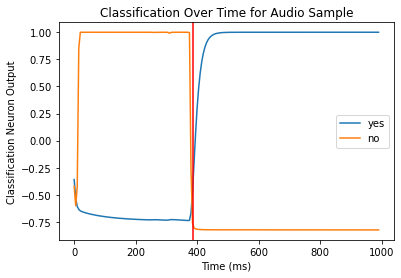

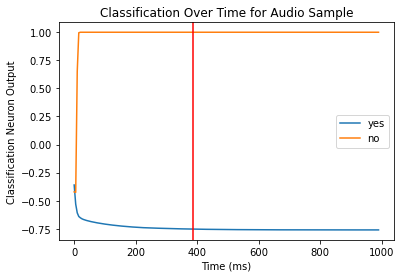

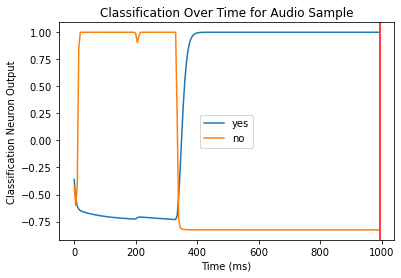

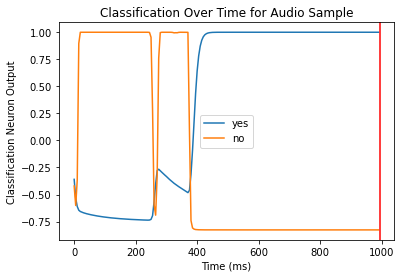

In [9]:
def classification_over_time(path, sim_set):
    gt = None
    if sim_set.raw_wav:
        gt = getAudioGammatone(path, sim_set.plot, verbose = False)
    else:
        gt = loadGammatone(path)
    
    post_mask_len = sim_set.post_mask_len
    post_pad_len = sim_set.post_pad_len
    
    dummyset = DummyDataset(gt, None, post_mask_len = post_mask_len, post_pad_len = post_pad_len)
    dummyloader = DataLoader(dataset=dummyset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=False)
    src, seq_len, _, primer_len = next(iter(dummyloader))
    _, _, output = recursive_model.forward(src, seq_len)
    output = output.squeeze(1)

    t_class = output[primer_len[0]:, -model_settings.n_tgt_class:]
    t_class = t_class.cpu().detach().numpy()
    if sim_set.plot:
        plot_classification(t_class, sim_set)
    return t_class, gt[0]

def plot_classification(t_class, sim_set):
    hop_ms = model_settings.hop_ms
    t = range(0, hop_ms*len(t_class), hop_ms)
    for i in range(model_settings.n_tgt_class):
        label = model_settings.tgt_classes[i]
        plt.plot(t, t_class[:,i], label = label)
    plt.title('Classification Over Time for Audio Sample')
    plt.xlabel('Time (ms)')
    plt.ylabel('Classification Neuron Output')
    plt.legend()
    plt.axvline(hop_ms*(len(t_class)-sim_set.post_mask_len), color='red')
    plt.show()

def classification_test():
    folder = file_settings.gammatone_test_folder
    sim_set = SimulationSettings()
    sim_set.plot = True
    sim_set.raw_wav = False
    sim_set.post_mask_len = 122
    classification_over_time(folder + 'gammatone_yesf2e59fea_nohash_0.pkl', sim_set)
    classification_over_time(folder + 'gammatone_yesf2e59fea_nohash_1.pkl', sim_set)
    sim_set.post_mask_len = 0
    classification_over_time(folder + 'gammatone_yesf2e59fea_nohash_2.pkl', sim_set)
    classification_over_time(folder + 'gammatone_yesf2e59fea_nohash_3.pkl', sim_set)

classification_test()

# Mask Length Search

Produce plots of classification accuracy as a function of post mask length. 

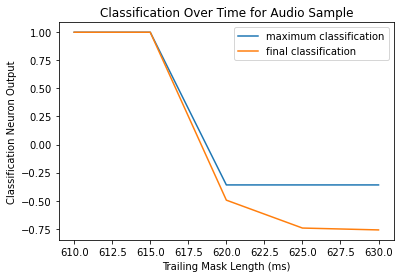

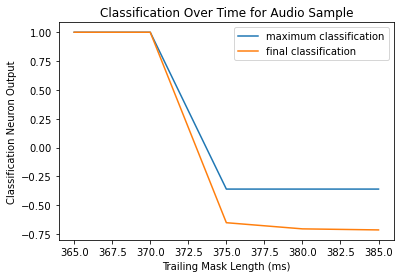

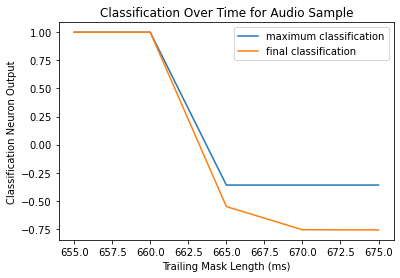

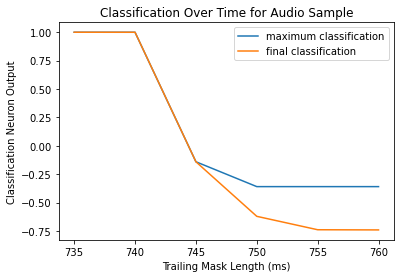

In [10]:
"""
Look at classification accuracy as a function of trailing mask length. 
"""
def classify_with_post_masks(path, raw_wav = True, mask_len_min = 0, mask_len_max = 191):
    class_max = []
    class_final = []
    for i in range(mask_len_min, mask_len_max):
        sim_set = SimulationSettings()
        sim_set.raw_wav = raw_wav
        sim_set.post_mask_len = i
        t_class = classification_over_time(path, sim_set)
        t_class_0 = t_class[0][:,0]
        class_max.append(np.max(t_class_0))
        class_final.append(t_class_0[-1])
        
    label = 'maximum classification'
    t = range(5*mask_len_min, 5*mask_len_max, 5)
    plt.plot(t, class_max, label = label)
    label = 'final classification'
    plt.plot(t, class_final, label = label)
    plt.title('Classification Over Time for Audio Sample')
    plt.xlabel('Trailing Mask Length (ms)')
    plt.ylabel('Classification Neuron Output')
    plt.legend()
    plt.show()
    
gammatone_test_folder = file_settings.gammatone_test_folder
classify_with_post_masks(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl', raw_wav = False,
                        mask_len_min = 122, mask_len_max = 127)
#critical mask length: 123 samples
classify_with_post_masks(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_1.pkl', raw_wav = False,
                        mask_len_min = 73, mask_len_max = 78)
#critical mask length: 74 samples
"""
classify_with_post_masks('../speech_commands/gammatone/test_redo/gammatone_yesf2e59fea_nohash_2.pkl', raw_wav = False,
                        mask_len_min = 120, mask_len_max = 170)
"""
classify_with_post_masks(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_2.pkl', raw_wav = False,
                        mask_len_min = 131, mask_len_max = 136)
#critical mask length: 132 samples
"""
classify_with_post_masks(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_3.pkl', raw_wav = False,
                        mask_len_min = 120, mask_len_max = 160)
"""
classify_with_post_masks(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_3.pkl', raw_wav = False,
                        mask_len_min = 147, mask_len_max = 153)
#critical mask length: 148 samples

In [11]:
%matplotlib qt5
def classify_with_post_masks_draft3(paths, mask_len_mins, mask_len_maxs, titles, raw_wav = False):
    plt.clf()
    for i in range(len(paths)):
        path = paths[i]
        mask_len_min = mask_len_mins[i]
        mask_len_max = mask_len_maxs[i]
        class_max = []
        class_final = []
        for j in range(mask_len_min, mask_len_max):
            sim_settings = SimulationSettings()
            sim_settings.raw_wav = raw_wav
            sim_settings.post_mask_len = j
            t_class = classification_over_time(path, sim_settings)
            t_class_0 = t_class[0][:,0]
            class_max.append(np.max(t_class_0))
            class_final.append(t_class_0[-1])
        label = 'maximum'
        t = range(5*mask_len_min, 5*mask_len_max, 5)
        plt.subplot(2, 2, i + 1)
        plt.plot(t, class_max, label = label, linestyle = '--')
        label = 'final'
        plt.plot(t, class_final, label = label)
        if (i == 2):
            plt.xlabel('Trailing Mask Length (ms)')
        if (i == 0):
            plt.ylabel('Classification Neuron Output')
        #plt.title(titles[i])
        plt.legend()
    #plt.suptitle('Classification Over Time for Audio Sample', fontsize = 20)
    plt.show()
    
paths = []
paths.append(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl')
paths.append(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_1.pkl')
paths.append(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_2.pkl')
paths.append(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_3.pkl')
mask_len_mins = [122, 73, 131, 147]
mask_len_maxs = [127, 78, 136, 152]
titles = ['yes/f2e59fea_nohash_0.wav','yes/f2e59fea_nohash_1.wav',
              'yes/f2e59fea_nohash_2.wav','yes/f2e59fea_nohash_3.wav']

classify_with_post_masks_draft3(paths, mask_len_mins, mask_len_maxs, titles)

# Play Audio

A function to play an audio file. This is used for manual determination of the time of the end of phonemes.

In [12]:
from IPython.display import Audio
from IPython.core.display import display

def play_audio(path, post_mask_len = 1):
    fs, data = wavfile.read(path)
    t_post_mask = np.int(fs*post_mask_len*0.001)
    data[-t_post_mask:] = np.zeros(t_post_mask)
    print(len(data))
    print(type(data.astype(np.float64, order='C')[0]))
    display(Audio(data.astype(np.float32, order='C') / 32768.0, rate=fs))
    
play_audio(file_settings.sound_file_folder_yes + 'f2e59fea_nohash_0.wav', post_mask_len = 130)

16000
<class 'numpy.float64'>


# Modulation

The core of the notebook. The simulate_modulation() function consists of multiple subroutines, which deal with running the classifier at different points of the audio file. 

In [13]:
def modulate_step(hidden_step, modulate_factor):
    """
    hidden_step: a tensor of (1, 1, hidden_size)
    modulate_factor: a scalar from -2.0 to 2.0 that is added onto the hidden state
    """
    new_hidden_step = torch.clamp(torch.add(hidden_step, modulate_factor), -1.0, 1.0)
    return new_hidden_step
    
def pre_modulation_simulation(src, t_mod_start, primer_len, return_hidden):
    pre_mod_src = src[:t_mod_start, 0, :].unsqueeze(1)
    _, hidden, output = recursive_model.forward(pre_mod_src, [t_mod_start])
    output = output.squeeze(1)
    t_class = output[primer_len[0]:, -model_settings.n_tgt_class:]
    if return_hidden:
        hidden_series = output[primer_len[0]:, :]
    else:
        hidden_series = None
    return hidden, output, t_class, hidden_series

def post_modulation_simulation(src, t_mod_start, mod_factors, hidden, t_class, return_hidden, hidden_series):
    t_mod_end = t_mod_start + len(mod_factors)
    post_mod_src = src[t_mod_end:, 0, :].unsqueeze(1)
    src_len = src.size(0)
    _, hidden, output = recursive_model.forward(post_mod_src, [src_len - t_mod_end], h0 = hidden)
    output = output.squeeze(1)
    t_class = torch.cat((t_class, output[:,-model_settings.n_tgt_class:]), 0)
    if return_hidden:
        hidden_series = torch.cat((hidden_series, output), 0)
    return hidden, output, t_class, hidden_series
    
def plot_modulation_results(t_class, sim_settings):
    t = range(0, 5*len(t_class), 5)
    if sim_settings.plot:
        for i in range(model_settings.n_tgt_class):
            label = model_settings.tgt_classes[i]
            if i%2 == 0:
                plt.plot(t, t_class[:,i], label = label, linestyle = '--')
            else:
                plt.plot(t, t_class[:,i], label = label)
        #plt.title('Classification Over Time for Audio Sample')
        plt.xlabel('Time (ms)')
        plt.ylabel('Classification Neuron Output')
        plt.legend()
        plt.axvline(5*(len(t_class)-sim_settings.post_mask_len), color='red')
        plt.axvline(5*sim_settings.t_mod_start, color='green')
        plt.show()
        
    if sim_settings.tgt_class == 'yes':
        t_class_tgt = t_class[:,0]
    if sim_settings.tgt_class == 'no':
        t_class_tgt = t_class[:,1]
    class_final = t_class_tgt[-1]
    return class_final
    
    
def simulate_modulation(path, sim_settings, return_hidden = False, linestyle = 'solid'):
    gt = None
    gt_primer = None
    raw_wav = sim_settings.raw_wav
    priming_file = None #the priming file functionality was partially implemented, but not fully developed
    if raw_wav:
        gt = getAudioGammatone(path, model_settings, plot = False, verbose = False)
    else:
        gt = loadGammatone(path)
        if priming_file is not None:
            gt_primer = loadGammatone(priming_file)
            
    post_mask_len = sim_settings.post_mask_len
    post_pad_len = sim_settings.post_pad_len
    dummyset = DummyDataset(gt, gt_primer, post_mask_len = post_mask_len, post_pad_len = post_pad_len)
    dummyloader = DataLoader(dataset=dummyset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=False)
    src, seq_len, _, primer_len = next(iter(dummyloader))
    
    t_mod_start = sim_settings.t_mod_start
    hidden, output, t_class, hidden_series = pre_modulation_simulation(src, t_mod_start, primer_len, return_hidden)
    
    mod_factors = sim_settings.mod_factors
    for i in range(len(mod_factors)):
        hidden = modulate_step(hidden, mod_factors[i])
        mod_src = src[sim_settings.t_mod_start + i, 0, :].unsqueeze(0).unsqueeze(0)
        _, hidden, output = recursive_model.forward(mod_src, [1], h0 = hidden)
        output = output.squeeze(1)
        t_class = torch.cat((t_class, output[0,-model_settings.n_tgt_class:].unsqueeze(0)), 0)
        if return_hidden:
            hidden_series = torch.cat((hidden_series, output[0,:].unsqueeze(0)), 0)
        
    hidden, output, t_class, hidden_series = post_modulation_simulation(src, t_mod_start, mod_factors, hidden,
                                                                        t_class, return_hidden, hidden_series)
    
    t = range(0, 5*len(t_class), 5)
    t_class = t_class.cpu().detach().numpy()
    class_final = plot_modulation_results(t_class, sim_settings)
    if return_hidden:
        return class_final, hidden_series
    else:
        return class_final
    
mod_settings = SimulationSettings()
mod_settings.plot = True
mod_settings.raw_wav = False
mod_settings.post_mask_len = 123 + 40
mod_settings.post_pad_len = 40
mod_settings.t_mod_start = 199 - 123 + 5
mod_settings.mod_factors = [-0.1, -0.2, -0.3, -0.1]
simulate_modulation(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl', mod_settings)

0.9999602

# Sample search

Here we search the sample set for examples of correctly classified and falsely classified samples. These sets were used in the thesis, and found file names were hard-coded later on in the notebook. This circumvents the need to search for samples each time the notebook is run.

In [14]:
import os

def squeeze_tgts(numerical_labels, tgt_classes, class_dict):
    filtered_labels = []
    for i, label in enumerate(tgt_classes):
        if class_dict[label] in numerical_labels:
            filtered_labels.append(i)
    return filtered_labels

def compile_filelist():
    csv_path = '../speech_commands/commands.pkl'
    folder = gammatone_test_folder
    file_prefix = 'gammatone_'
    (file_data, class_dict) = pickle.load(open(csv_path, "rb"))
    #print(class_dict)
    file_list = []
    tgt_list = []
    tgt_classes = ['yes', 'no']
    n_tgt_class = len(tgt_classes)
    for row in file_data:
        if row[-1] == 'test':
            squeezed_tgts = squeeze_tgts(row[1], tgt_classes, class_dict)
            if len(squeezed_tgts) != 0:
                comps = row[0].split('/')
                pickle_name = comps[0] + comps[1].split('.')[0]
                path = os.path.join(folder, file_prefix + pickle_name + '.pkl')
                file_list.append(path)
                tgt_list.append(squeezed_tgts)
    return file_list, tgt_list

#print(compile_filelist())

def search_samples(failed = True, n_samples = -1):
    file_list, tgt_list = compile_filelist()
    false_negs = []
    false_pos = []
    true_negs = []
    true_pos = []
    for i in range(len(file_list)):
        path = file_list[i]
        tgt = tgt_list[i][0]
        sim_settings = SimulationSettings()
        sim_settings.raw_wav = False
        t_class, _ = classification_over_time(path, sim_settings)
        t_class_yes = t_class[:,0]
        class_final = t_class_yes[-1]
        if class_final < 0.0 and tgt == 0 and failed:
            print('Found false negative of yes: ' + path)
            false_negs.append(path)
        if class_final > 0.0 and tgt == 1 and failed:
            print('Found false positive of yes: ' + path)
            false_pos.append(path)
        if class_final < 0.0 and tgt == 1 and not failed:
            print('Found true negative of yes: ' + path)
            true_negs.append(path)
        if class_final > 0.0 and tgt == 0 and not failed:
            print('Found true positive of yes: ' + path)
            true_pos.append(path)
        if failed:
            n_found = len(false_negs) + len(false_pos)
        else:
            n_found = len(true_negs) + len(true_pos)
        if n_found == n_samples:
            if failed:
                return false_negs, false_pos
            else:
                return true_negs, true_pos

def search_failed_samples():
    return search_samples()
    
#search_samples()
search_samples(failed = False, n_samples = 20)

Found true negative of yes: ../speech_commands/gammatone/test_redo/gammatone_no4c6167ca_nohash_0.pkl
Found true negative of yes: ../speech_commands/gammatone/test_redo/gammatone_noc9b5ff26_nohash_1.pkl
Found true positive of yes: ../speech_commands/gammatone/test_redo/gammatone_yesaa233654_nohash_0.pkl
Found true positive of yes: ../speech_commands/gammatone/test_redo/gammatone_yesf2e59fea_nohash_2.pkl
Found true positive of yes: ../speech_commands/gammatone/test_redo/gammatone_yes5eb5fc74_nohash_1.pkl
Found true negative of yes: ../speech_commands/gammatone/test_redo/gammatone_noa7216980_nohash_1.pkl
Found true positive of yes: ../speech_commands/gammatone/test_redo/gammatone_yesaa80f517_nohash_4.pkl
Found true positive of yes: ../speech_commands/gammatone/test_redo/gammatone_yese1469561_nohash_1.pkl
Found true negative of yes: ../speech_commands/gammatone/test_redo/gammatone_no47d01978_nohash_0.pkl
Found true positive of yes: ../speech_commands/gammatone/test_redo/gammatone_yes26b28e

(['../speech_commands/gammatone/test_redo/gammatone_no4c6167ca_nohash_0.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_noc9b5ff26_nohash_1.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_noa7216980_nohash_1.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_no47d01978_nohash_0.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_no189cbabe_nohash_3.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_noe41a903b_nohash_3.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_nodb24628d_nohash_3.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_noe1469561_nohash_4.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_no893705bb_nohash_0.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_nof428ca69_nohash_0.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_no82b99576_nohash_1.pkl'],
 ['../speech_commands/gammatone/test_redo/gammatone_yesaa233654_nohash_0.pkl',
  '../speech_commands/gammatone/test_redo/gammatone_yesf2e59fe

# Random wave search

In [15]:
#warning: slow to process, only run once!
#false_negs, false_pos = search_failed_samples()

In [16]:
import random
import math

def generate_linear_wave(params, n_t_steps):
    inflated_wave = None
    previous_r = 0.0
    n_dim = len(params)
    for i in range(n_dim):
        r = params[i]
        wave_section = np.linspace(previous_r, r, num = n_t_steps)
        previous_r = r
        if inflated_wave is None:
            inflated_wave = wave_section
        else:
            inflated_wave = np.concatenate((inflated_wave, wave_section))
    final_wave = []
    for i in range(n_t_steps):
        idx = (i + 1) * n_dim - 1
        final_wave.append(inflated_wave[idx])
    final_wave = np.asarray(final_wave)
    return final_wave

def generate_sine_series_wave(params, n_t_steps):
    x = np.linspace(0, 1, num = n_t_steps)
    final_wave = np.zeros(n_t_steps)
    n_dim = len(params)
    for i in range(n_dim):
        comp = params[i] * np.sin((i+1)*math.pi*x)
        final_wave += comp
    final_wave /= (n_dim/2)
    return final_wave

def generate_wave(method, params, n_t_steps):
    if method == 'white noise':
        final_wave = generate_linear_wave(params, n_t_steps)
        return final_wave
    if method == 'sine series':
        final_wave = generate_sine_series_wave(params, n_t_steps)
        return final_wave

def generate_random_parameters(n_dim, scale = 1.0):
    rand_params = []
    for i in range(n_dim):
        r = 2.0 * random.random() - 1.0
        rand_params.append(scale * r)
    return rand_params

def generate_random_wave(n_dim, n_t_steps, method = 'white noise'):
    params = generate_random_parameters(n_dim, 1.0)
    return generate_wave(method, params, n_t_steps)
        
def visualize_wave(method, params, n_t_steps):
    wave = generate_wave(method, params, n_t_steps)
    t = range(0, 5*n_t_steps, 5)
    plt.plot(t, wave)
    plt.title('Wave')
    plt.xlabel('Time (ms)')
    plt.ylabel('Modulation value')
    plt.show()
    
r_params = generate_random_parameters(10)
visualize_wave('sine series', r_params, 20)

#note: does not produce intelligent results; dead code for now
def random_search():
    wave_dim = 10
    n_t_steps = 20
    best_wave = None
    best_wave_loss = math.inf
    for i in range(10**3):
        r_wave = generate_random_wave(wave_dim, n_t_steps)
        loss = 0.0
        for path in false_negs:
            #print(path)
            if path == '../speech_commands/gammatone/test_redo/gammatone_yesfdb5155e_nohash_1.pkl' \
                or path == '../speech_commands/gammatone/test_redo/gammatone_yesfdb5155e_nohash_0.pkl' \
                or path == '../speech_commands/gammatone/test_redo/gammatone_yesc9e251d2_nohash_0.pkl' \
                or path == '../speech_commands/gammatone/test_redo/gammatone_yesa9f54d8d_nohash_0.pkl':
                continue
            sample_fitness = simulate_modulation(path, plot = False,
                        raw_wav = False, post_pad_len = 40,
                        t_mod_start = 199, mod_factors = r_wave)
            #mean squared error
            loss += (1.0 - sample_fitness)**2
        loss = loss / (len(false_negs) - 4)
        if loss < best_wave_loss:
            best_wave = r_wave
            best_wave_loss = loss
        if i % 100 == 0:
            print('Processed random wave count: ' + str(i + 1))
            print('Best found wave: ' + str(best_wave))
            print('Best found wave loss: ' + str(best_wave_loss))
            t = range(0, 5*n_t_steps, 5)
            plt.plot(t, best_wave)
            plt.title('Best waveform for correcting false negatives of Yes')
            plt.xlabel('Time (ms)')
            plt.ylabel('Modulation value')
            plt.show()
            
    return best_wave, best_wave_loss
    
#random_search()

In [17]:
def visualize_modulation_wave(mod_wave):
    for path in false_negs:
        simulate_modulation(path, raw_wav = False, post_mask_len = 0,
            post_pad_len = 40, t_mod_start = 199, mod_factors = mod_wave)
    
best_wave = [-0.11647599456972771, -0.2458937663138696, -0.06707525906562362, 0.1316119712102053, -0.38295722677635324, -0.9547007800947518, -0.45583807472709925, 0.09845382012584802, 0.3324149535048042, 0.5923717683703111, 0.030134228104449656, -0.5945741499687298, -0.4706904112861347, -0.33304181274991795, -0.08696630205797354, 0.18645093204418695, -0.19518821558564048, -0.6192317129521154, 0.12781918522202762, 0.9578757387488532]
#visualize_modulation_wave(best_wave)

# Handpicked Samples

Here one can listen to the handpicked samples. For each sample, the 'post mask' (ie. the silenced time steps of the audio sample) has been manually calibrated to coincide with the end of the last phoneme in the word. 

In [18]:
def observe_sample(class_str, file_id, mask_len):
    print('Observing sample ' + file_id + ' with correct class ' + class_str)
    sim_settings = SimulationSettings()
    sim_settings.raw_wav = False
    sim_settings.post_pad_len = 40
    sim_settings.post_mask_len = sim_settings.post_pad_len + mask_len
    classification_over_time(gammatone_test_folder + 'gammatone_' + class_str + file_id + '.pkl', sim_settings)
    if class_str == 'yes':
        play_audio(file_settings.sound_file_folder_yes + file_id + '.wav', post_mask_len = mask_len)
    if class_str == 'no':
        play_audio(file_settings.sound_file_folder_no + file_id + '.wav', post_mask_len = mask_len)
    

observe_sample('yes', '37dca74f_nohash_4', 60)
observe_sample('yes', '798f702a_nohash_0', 15)
observe_sample('yes', '81dc4a94_nohash_0', 75)
observe_sample('yes', '27c30960_nohash_0', 10)
observe_sample('yes', 'e1469561_nohash_3', 71)

observe_sample('yes', '3df9a3d4_nohash_0', 65)
observe_sample('yes', '37dca74f_nohash_1', 112)
observe_sample('yes', '964e8cfd_nohash_1', 52)
observe_sample('yes', '3df9a3d4_nohash_1', 65)
observe_sample('yes', '0ea0e2f4_nohash_0', 25)

observe_sample('yes', 'd1a4fb3f_nohash_0', 40)
observe_sample('yes', '881583a6_nohash_0', 55)
observe_sample('yes', 'd1a4fb3f_nohash_1', 20)
observe_sample('no', '97f4c236_nohash_2', 52)
observe_sample('no', '9a356ab9_nohash_0', 85)

observe_sample('yes', 'f297e878_nohash_0', 5)
observe_sample('yes', '3b4f8f24_nohash_3', 55)
observe_sample('yes', '37dca74f_nohash_2', 25)
observe_sample('yes', '37dca74f_nohash_3', 30)
observe_sample('yes', '37dca74f_nohash_0', 20)

observe_sample('no', '692a88e6_nohash_1', 45)
observe_sample('no', '8056e897_nohash_0', 15)
observe_sample('yes', '9e2ce5e3_nohash_0', 60)
observe_sample('yes', 'c9b5ff26_nohash_1', 65)
observe_sample('no', '97f4c236_nohash_0', 25)

Observing sample 37dca74f_nohash_4 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 798f702a_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 81dc4a94_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 27c30960_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample e1469561_nohash_3 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 3df9a3d4_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 37dca74f_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 964e8cfd_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 3df9a3d4_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 0ea0e2f4_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample d1a4fb3f_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 881583a6_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample d1a4fb3f_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 97f4c236_nohash_2 with correct class no
16000
<class 'numpy.float64'>


Observing sample 9a356ab9_nohash_0 with correct class no
16000
<class 'numpy.float64'>


Observing sample f297e878_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 3b4f8f24_nohash_3 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 37dca74f_nohash_2 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 37dca74f_nohash_3 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 37dca74f_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 692a88e6_nohash_1 with correct class no
16000
<class 'numpy.float64'>


Observing sample 8056e897_nohash_0 with correct class no
16000
<class 'numpy.float64'>


Observing sample 9e2ce5e3_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample c9b5ff26_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 97f4c236_nohash_0 with correct class no
16000
<class 'numpy.float64'>


In [19]:
observe_sample('no', '4c6167ca_nohash_0', 80)
observe_sample('no', 'c9b5ff26_nohash_1', 5)
observe_sample('yes', 'aa233654_nohash_0', 20)
observe_sample('yes', 'f2e59fea_nohash_2', 70)
observe_sample('yes', '5eb5fc74_nohash_1', 1)
observe_sample('no', 'a7216980_nohash_1', 50)
observe_sample('yes', 'aa80f517_nohash_4', 80)
observe_sample('yes', 'e1469561_nohash_1', 20)
observe_sample('no', '47d01978_nohash_0', 90)
observe_sample('yes', '26b28ea7_nohash_0', 40)
observe_sample('no', '189cbabe_nohash_3', 50)
observe_sample('no', 'e41a903b_nohash_3', 110)
observe_sample('no', 'db24628d_nohash_3', 80)
observe_sample('no', 'e1469561_nohash_4', 80)
observe_sample('no', '893705bb_nohash_0', 1)
observe_sample('no', 'f428ca69_nohash_0', 40)
observe_sample('yes', 'd962e5ac_nohash_4', 90)
observe_sample('yes', '4845bb10_nohash_1', 15)
observe_sample('yes', 'b83c1acf_nohash_1', 40)
observe_sample('no', '82b99576_nohash_1', 25)

Observing sample 4c6167ca_nohash_0 with correct class no
16000
<class 'numpy.float64'>


Observing sample c9b5ff26_nohash_1 with correct class no
16000
<class 'numpy.float64'>


Observing sample aa233654_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample f2e59fea_nohash_2 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 5eb5fc74_nohash_1 with correct class yes
8192
<class 'numpy.float64'>


Observing sample a7216980_nohash_1 with correct class no
16000
<class 'numpy.float64'>


Observing sample aa80f517_nohash_4 with correct class yes
16000
<class 'numpy.float64'>


Observing sample e1469561_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 47d01978_nohash_0 with correct class no
16000
<class 'numpy.float64'>


Observing sample 26b28ea7_nohash_0 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 189cbabe_nohash_3 with correct class no
16000
<class 'numpy.float64'>


Observing sample e41a903b_nohash_3 with correct class no
16000
<class 'numpy.float64'>


Observing sample db24628d_nohash_3 with correct class no
16000
<class 'numpy.float64'>


Observing sample e1469561_nohash_4 with correct class no
16000
<class 'numpy.float64'>


Observing sample 893705bb_nohash_0 with correct class no
16000
<class 'numpy.float64'>


Observing sample f428ca69_nohash_0 with correct class no
16000
<class 'numpy.float64'>


Observing sample d962e5ac_nohash_4 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 4845bb10_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample b83c1acf_nohash_1 with correct class yes
16000
<class 'numpy.float64'>


Observing sample 82b99576_nohash_1 with correct class no
14336
<class 'numpy.float64'>


# Random Wave Search with Handpicked Samples

Here we generate white noise waveforms and modulate the model with it during the playback of an audio sample. The best found waveform is recorded.

In [20]:
def get_failed_yes_samples():
    paths = []
    paths.append(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_4.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes798f702a_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes81dc4a94_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes27c30960_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yese1469561_nohash_3.pkl')

    paths.append(gammatone_test_folder + 'gammatone_yes3df9a3d4_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_1.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes964e8cfd_nohash_1.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes3df9a3d4_nohash_1.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes0ea0e2f4_nohash_0.pkl')

    paths.append(gammatone_test_folder + 'gammatone_yesd1a4fb3f_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes881583a6_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yesd1a4fb3f_nohash_1.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yesf297e878_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes3b4f8f24_nohash_3.pkl')

    paths.append(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_2.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_3.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yes9e2ce5e3_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_yesc9b5ff26_nohash_1.pkl')

    mask_lens = []
    mask_lens.append(60)
    mask_lens.append(15)
    mask_lens.append(75)
    mask_lens.append(10)
    mask_lens.append(70)

    mask_lens.append(65)
    mask_lens.append(112)
    mask_lens.append(52)
    mask_lens.append(65)
    mask_lens.append(25)

    mask_lens.append(40)
    mask_lens.append(55)
    mask_lens.append(20)
    mask_lens.append(5)
    mask_lens.append(55)

    mask_lens.append(25)
    mask_lens.append(30)
    mask_lens.append(20)
    mask_lens.append(60)
    mask_lens.append(65)
    
    return paths, mask_lens

In [21]:
paths, mask_lens = get_failed_yes_samples()
pad_len = 120

def handpick_random_search(paths, mask_lens, method = 'white noise', tgt_class = 'yes', raw_wav = False):    
    wave_dim = 10
    n_t_steps = 20
    scale = 1.0
    best_params = np.zeros(wave_dim)
    best_wave_loss = math.inf
    for i in range(10**3):
        r_params = generate_random_parameters(wave_dim, scale)
        r_wave = generate_wave(method, r_params, n_t_steps)
        #mean squared error
        loss = 0.0
        for j in range(len(paths)):
            sim_settings = SimulationSettings()
            sim_settings.plot = False
            sim_settings.raw_wav = raw_wav
            sim_settings.post_pad_len = pad_len
            sim_settings.post_mask_len = pad_len + mask_lens[j]
            sim_settings.t_mod_start = 199 - mask_lens[j]
            sim_settings.mod_factors = r_wave
            sim_settings.tgt_class = tgt_class
            sample_fitness = simulate_modulation(paths[j], sim_settings)
            loss += (1.0 - sample_fitness)**2
        loss = loss / (len(paths))
        if loss < best_wave_loss:
            best_params = r_params
            best_wave_loss = loss
        if i % 20 == 0:
            print('Processed random wave count: ' + str(i + 1))
            print('Best found parameters: ' + str(best_params))
            print('Best found wave loss: ' + str(best_wave_loss))
            visualize_wave(method, best_params, n_t_steps)
            
    return best_params, best_wave_loss

#this is slow! run only to find a new optimal modulation wave
#handpick_random_search(paths, mask_lens, method = 'sine series')

In [22]:
def visualize_waves_draft3(method, paramss, n_t_steps, titles):
    %matplotlib qt5
    plt.clf()
    for i in range(len(paramss)):
        params = paramss[i]
        smooth_wave = generate_wave(method, params, 5*n_t_steps)
        t = range(0, 5*n_t_steps, 5)
        smooth_t = range(0, 5*n_t_steps)
        wave = smooth_wave[0::5]
        plt.subplot(1, 2, i + 1)
        plt.plot(smooth_t, smooth_wave)
        plt.scatter(t, wave, color='green')
        plt.title(titles[i])
        if i == 0:
            plt.ylabel('Modulation value')
            
        plt.xlabel('Time (ms)')
            
    #plt.suptitle('Optimal Modulation Waves', fontsize = 20)
    plt.show()
    
yes_params = [0.6298570101066092,
              0.8202190390131667,
              0.5860336887454312,
              -0.4761214422085458,
              0.7819927087447869,
              -0.8179176825679229,
              -0.605778448572734,
              -0.12777620412026813,
              -0.20169535785399817,
              0.11784507961878599]
no_params = [-0.9335310340075196,
  0.9156008416945323,
  0.7831214535846867,
  0.43290751048591236,
  -0.743333799906648,
  0.9572430730194064,
  -0.9276067456406965,
  0.5820498229837252,
  -0.7764164691780779,
  -0.32969819553166335]
crit_params = [-0.5346272647888257,
               0.3229890480431752,
               -0.14623811281074262,
               -0.19049015799007618,
               -0.6823160119550415,
               -0.44400749204752366,
               0.42184281448838745,
               0.18014864173025757,
               0.9498531261807135,
               -0.04298462954603144]
titles = ['Class Yes', 'Class No', 'Critically Noisy Samples, Class No']
visualize_waves_draft3('sine series', [yes_params, no_params], 20, titles)



# Gradient Descent

This is code that gradually optimizes a given set of parameters, utilizing the stochastic gradient descent algorithm. 

In [23]:
def gradient(method, params, n_t_steps, path, mask_len, tgt_class = 'yes'):
    base_wave = generate_wave(method, params, n_t_steps)
    sim_settings = SimulationSettings()
    sim_settings.raw_wav = False
    sim_settings.post_mask_len = pad_len + mask_len
    sim_settings.post_pad_len = pad_len
    sim_settings.t_mod_start = 199 - mask_len
    sim_settings.mod_factors = base_wave
    base_fit = simulate_modulation(path, sim_settings)
    dim_delta = 0.001
    grad = []
    for i in range(len(params)):
        nudge_params = params
        nudge_params[i] = params[i] + dim_delta
        nudge_wave = generate_wave(method, nudge_params, n_t_steps)
        sim_settings.mod_factors = nudge_wave
        dim_fit = simulate_modulation(path, sim_settings)
        dim_grad = -(dim_fit - base_fit)/dim_delta
        grad.append(dim_grad)
    grad = np.asarray(grad)
    return grad

def loss(method, params, n_t_steps, paths, mask_lens, tgt_class = 'yes'):
    loss = 0.0
    mod_wave = generate_wave(method, params, n_t_steps)
    sim_settings = SimulationSettings()
    sim_settings.raw_wav = False
    sim_settings.post_pad_len = pad_len
    sim_settings.mod_factors = mod_wave
    for i in range(len(paths)):
        sim_settings.post_mask_len = pad_len + mask_lens[i]
        sim_settings.t_mod_start = 199 - mask_lens[i]
        sample_fitness = simulate_modulation(paths[i], sim_settings)
    loss = loss / (len(paths))
    return loss

def stochastic_gradient_descent(method, params, n_t_steps, step_delta, n_steps, paths, mask_lens, tgt_class = 'yes'):
    min_params = params
    old_loss = loss(method, params, n_t_steps, paths, mask_lens)
    for i in range(n_steps):
        idx = random.choice(range(len(paths)))
        path = paths[idx]
        mask_len = mask_lens[idx]
        grad = gradient(method, params, n_t_steps, path, mask_len, tgt_class)
        min_params = min_params - step_delta * grad
        new_loss = loss(method, min_params, n_t_steps, paths, mask_lens)
        if i % 10 == 0:
            print('Gradient descent step: ' + str(i + 1) + ' at loss: ' + str(new_loss))
        if new_loss > old_loss:
            break
        else:
            old_loss = new_loss
    return min_params, new_loss
    
def visualize_handpick_modulation_wave(method, params, n_t_steps, paths, mask_lens, tgt_class = 'yes'):
    mod_wave = generate_wave(method, params, n_t_steps)
    loss = 0.0
    sim_settings = SimulationSettings()
    sim_settings.plot = True
    sim_settings.raw_wav = False
    sim_settings.post_pad_len = pad_len
    sim_settings.mod_factors = mod_wave
    sim_settings.tgt_class = tgt_class
    for i in range(len(paths)):
        sim_settings.mask_len = pad_len + mask_lens[i]
        sim_settings.t_mod_start = 199 - mask_lens[i]
        sample_fitness = simulate_modulation(paths[i], sim_settings)
        loss += (1.0 - sample_fitness)**2
    loss = loss / (len(paths))
    print(loss)
    
"""
test_params = [0.25854742232173145, -0.2298212519697329, 0.9078832254125344, 0.27269608719288296, -0.15927659641339686, 0.1924559319399315, -0.2762426307189967, -0.6036060526961238, 0.4682144316830654, 0.6005795835629366]
#stochastic_gradient_descent('white noise', test_params, 20, 0.001, 100, paths, mask_lens)
post_descent_params = [ 0.25946791, -0.22900579,  0.90854205,  0.27298822, -0.16124962, 0.18717015, -0.28610784, -0.61872017,  0.44718384,  0.56667087]
visualize_handpick_modulation_wave('white noise', post_descent_params, 20, paths, mask_lens)
"""
"""
sine_params = [0.718220309906618, 0.28557310393231283, 0.18410224266560782, -0.6310874524681505, -0.10404026581010206, 0.2597130662541425, 0.3834106004629534, 0.6505742084493438, 0.8585041119387515, -0.574853157855036]
#stochastic_gradient_descent('sine series', sine_params, 20, 0.001, 100, paths, mask_lens)
post_descent_params = [ 0.70929787,  0.27761107,  0.17216547, -0.6417637 , -0.11688911,
         0.2474378 ,  0.36947487,  0.63718028,  0.84397168, -0.58909019]
visualize_handpick_modulation_wave('sine series', post_descent_params, 20, paths, mask_lens)
"""

"\nsine_params = [0.718220309906618, 0.28557310393231283, 0.18410224266560782, -0.6310874524681505, -0.10404026581010206, 0.2597130662541425, 0.3834106004629534, 0.6505742084493438, 0.8585041119387515, -0.574853157855036]\n#stochastic_gradient_descent('sine series', sine_params, 20, 0.001, 100, paths, mask_lens)\npost_descent_params = [ 0.70929787,  0.27761107,  0.17216547, -0.6417637 , -0.11688911,\n         0.2474378 ,  0.36947487,  0.63718028,  0.84397168, -0.58909019]\nvisualize_handpick_modulation_wave('sine series', post_descent_params, 20, paths, mask_lens)\n"

# No -samples

In [24]:
def get_failed_no_samples():
    paths = []
    paths.append(gammatone_test_folder + 'gammatone_no97f4c236_nohash_2.pkl')
    paths.append(gammatone_test_folder + 'gammatone_no9a356ab9_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_no692a88e6_nohash_1.pkl')
    paths.append(gammatone_test_folder + 'gammatone_no8056e897_nohash_0.pkl')
    paths.append(gammatone_test_folder + 'gammatone_no97f4c236_nohash_0.pkl')

    mask_lens = []
    mask_lens.append(52)
    mask_lens.append(85)
    mask_lens.append(45)
    mask_lens.append(15)
    mask_lens.append(25)

    return paths, mask_lens

paths, mask_lens = get_failed_no_samples()
pad_len = 120

#handpick_random_search(paths, mask_lens, method = 'sine series', tgt_class = 'no')

In [25]:
no_params = [-0.9335310340075196,
  0.9156008416945323,
  0.7831214535846867,
  0.43290751048591236,
  -0.743333799906648,
  0.9572430730194064,
  -0.9276067456406965,
  0.5820498229837252,
  -0.7764164691780779,
  -0.32969819553166335]

visualize_handpick_modulation_wave('sine series', no_params, 20, paths, mask_lens, tgt_class = 'no')

0.8286825892132486


In [26]:
def visualize_handpick_modulation_wave_draft3(method, paramss, n_t_steps, paths, mask_lens, titles, tgt_class = 'yes'):
    plt.clf()
    for i in range(len(paramss)):
        params = paramss[i]
        path = paths[i]
        mod_wave = generate_wave(method, params, n_t_steps)
        loss = 0.0
        plt.subplot(2, 2, 2*i + 1)
        raw_wav = False
        if i == 2:
            raw_wav = True
        sim_settings = SimulationSettings()
        sim_settings.plot = True
        sim_settings.raw_wav = raw_wav
        sim_settings.post_mask_len = pad_len + mask_lens[i]
        sim_settings.post_pad_len = pad_len
        sim_settings.t_mod_start = 199 - mask_lens[i]
        sim_settings.mod_factors = [0]
        sim_settings.tgt_class = tgt_class
        sample_fitness = simulate_modulation(path, sim_settings)
        #plt.title(titles[2*i], fontsize = 10)
        if i != 0:
            plt.ylabel('')
        if i != 1:
            plt.xlabel('')
        plt.subplot(2, 2, 2*i + 2)
        sim_settings.mod_factors = mod_wave
        sample_fitness = simulate_modulation(path, sim_settings)
        plt.ylabel('')
        if i != 2:
            plt.xlabel('')
        #plt.title(titles[2*i + 1], fontsize = 10)
    #plt.suptitle('Modulation Effects on Selected Samples', fontsize = 20)
        
sample_paths = []
sample_paths.append(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_4.pkl')
sample_paths.append(gammatone_test_folder + 'gammatone_no97f4c236_nohash_2.pkl')
sample_paths.append('noisy_no4c6167ca_nohash_0.wav')
titles = []
titles.append('Yes Sample, Without Modulation')
titles.append('Yes Sample, With Modulation')
titles.append('No Sample, Without Modulation')
titles.append('No Sample, With Modulation')
titles.append('Noisy Sample, Without Modulation')
titles.append('Noisy Sample, With Modulation')
visualize_handpick_modulation_wave_draft3('sine series', [yes_params, no_params], 20,
                                          sample_paths, [60,52,80], titles)

# Critically Noisy Samples

This was prototype code that attempted to add noise to audio samples until the model failed to classify them correctly. This idea was later scrapped in favor of reducing the volume of the samples to induce classification failure. This new idea was never implemented, however.

In [27]:
"""
#reads a raw wav and returns that wav with some added noise
def generate_noisy_sample(path, scale):
    fs, data = wavfile.read(path)
    peak = np.iinfo(np.int16).max
    rand_vec = np.random.rand(len(data))
    rand_vec = scale * peak * rand_vec
    rand_vec = rand_vec.astype(np.int32)
    new_data = data.astype(np.int32)
    new_data = new_data + rand_vec
    new_data = np.clip(new_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max)
    new_data = new_data.astype(np.int16)
    
    path_split = path.split('/')
    #print(path.split('/'))
    new_file_name = 'noisy_' + path_split[-2] + path_split[-1]
    wavfile.write(new_file_name, fs, new_data.astype(np.int16))
    #print(new_data.astype(np.int16))
    return new_file_name

generate_noisy_sample(file_settings.sound_file_folder_no + '4c6167ca_nohash_0' + '.wav', 0.1)
"""

"\n#reads a raw wav and returns that wav with some added noise\ndef generate_noisy_sample(path, scale):\n    fs, data = wavfile.read(path)\n    peak = np.iinfo(np.int16).max\n    rand_vec = np.random.rand(len(data))\n    rand_vec = scale * peak * rand_vec\n    rand_vec = rand_vec.astype(np.int32)\n    new_data = data.astype(np.int32)\n    new_data = new_data + rand_vec\n    new_data = np.clip(new_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max)\n    new_data = new_data.astype(np.int16)\n    \n    path_split = path.split('/')\n    #print(path.split('/'))\n    new_file_name = 'noisy_' + path_split[-2] + path_split[-1]\n    wavfile.write(new_file_name, fs, new_data.astype(np.int16))\n    #print(new_data.astype(np.int16))\n    return new_file_name\n\ngenerate_noisy_sample(file_settings.sound_file_folder_no + '4c6167ca_nohash_0' + '.wav', 0.1)\n"

In [28]:
"""
def seek_sample_noise_limit(class_str, file_id, post_mask_len, post_pad_len, verbose = True):
    if class_str == 'yes':
        wav_path = sound_file_folder_yes + file_id + '.wav'
    if class_str == 'no':
        wav_path = sound_file_folder_no + file_id + '.wav'
        
    if verbose:
        print('Seeking sample noise limit of ' + wav_path)
        
    t_class, _ = classification_over_time(wav_path, plot = False, raw_wav = True, priming_file = None,
                             post_mask_len = post_mask_len, post_pad_len = post_pad_len)
    class_end = t_class[-1, :]
    argmax = np.argmax(class_end)
    #print(class_end)
    #print(argmax)
    noise_increment = 0.01
    for i in range(1, 200):
        noise_scale = i * noise_increment
        noisy_path = generate_noisy_sample(wav_path, noise_scale)
        t_class, _ = classification_over_time(noisy_path, plot = False, raw_wav = True, priming_file = None,
                             post_mask_len = post_mask_len + post_pad_len, post_pad_len = post_pad_len)
        class_end = t_class[-1, :]
        noisy_argmax = np.argmax(class_end)
        
        if noisy_argmax != argmax:
            return noise_scale
        
    
crit_noise_scale = seek_sample_noise_limit('no', '4c6167ca_nohash_0', 110, 30)
print(crit_noise_scale)
classification_over_time('noisy_no4c6167ca_nohash_0.wav', plot = True, raw_wav = True, priming_file = None,
                             post_mask_len = 110, post_pad_len = 30)
"""

"\ndef seek_sample_noise_limit(class_str, file_id, post_mask_len, post_pad_len, verbose = True):\n    if class_str == 'yes':\n        wav_path = sound_file_folder_yes + file_id + '.wav'\n    if class_str == 'no':\n        wav_path = sound_file_folder_no + file_id + '.wav'\n        \n    if verbose:\n        print('Seeking sample noise limit of ' + wav_path)\n        \n    t_class, _ = classification_over_time(wav_path, plot = False, raw_wav = True, priming_file = None,\n                             post_mask_len = post_mask_len, post_pad_len = post_pad_len)\n    class_end = t_class[-1, :]\n    argmax = np.argmax(class_end)\n    #print(class_end)\n    #print(argmax)\n    noise_increment = 0.01\n    for i in range(1, 200):\n        noise_scale = i * noise_increment\n        noisy_path = generate_noisy_sample(wav_path, noise_scale)\n        t_class, _ = classification_over_time(noisy_path, plot = False, raw_wav = True, priming_file = None,\n                             post_mask_len = pos

In [29]:
def produce_critically_noisy_batch():
    samples = []
    samples.append(['no', '4c6167ca_nohash_0', 80])
    samples.append(['no', 'c9b5ff26_nohash_1', 5])
    samples.append(['yes', 'aa233654_nohash_0', 20])
    samples.append(['yes', 'f2e59fea_nohash_2', 70])
    samples.append(['yes', '5eb5fc74_nohash_1', 1])
    samples.append(['no', 'a7216980_nohash_1', 50])
    samples.append(['yes', 'aa80f517_nohash_4', 80])
    samples.append(['yes', 'e1469561_nohash_1', 20])
    samples.append(['no', '47d01978_nohash_0', 90])
    samples.append(['yes', '26b28ea7_nohash_0', 40])
    samples.append(['no', '189cbabe_nohash_3', 50])
    samples.append(['no', 'e41a903b_nohash_3', 110])
    samples.append(['no', 'db24628d_nohash_3', 80])
    samples.append(['no', 'e1469561_nohash_4', 80])
    samples.append(['no', '893705bb_nohash_0', 1])
    samples.append(['no', 'f428ca69_nohash_0', 40])
    samples.append(['yes', 'd962e5ac_nohash_4', 90])
    samples.append(['yes', '4845bb10_nohash_1', 15])
    samples.append(['yes', 'b83c1acf_nohash_1', 40])
    samples.append(['no', '82b99576_nohash_1', 25])
    
    for sample in samples:
        limit = seek_sample_noise_limit(sample[0], sample[1], sample[2] + 30, 30)
        sample_name = sample[0] + sample[1] + '.wav'
        print('Noise limit of ' + sample_name + ' : ' + str(limit))
        
#produce_critically_noisy_batch()

In [30]:
"""
---PRINT OUT OF PREVIOUS CELL---

Seeking sample noise limit of ../speech_commands/no/4c6167ca_nohash_0.wav
Noise limit of no4c6167ca_nohash_0.wav : 0.12
Seeking sample noise limit of ../speech_commands/no/c9b5ff26_nohash_1.wav
Noise limit of noc9b5ff26_nohash_1.wav : 0.19
Seeking sample noise limit of ../speech_commands/yes/aa233654_nohash_0.wav
Noise limit of yesaa233654_nohash_0.wav : None
Seeking sample noise limit of ../speech_commands/yes/f2e59fea_nohash_2.wav
Noise limit of yesf2e59fea_nohash_2.wav : None
Seeking sample noise limit of ../speech_commands/yes/5eb5fc74_nohash_1.wav
Noise limit of yes5eb5fc74_nohash_1.wav : 0.01
Seeking sample noise limit of ../speech_commands/no/a7216980_nohash_1.wav
Noise limit of noa7216980_nohash_1.wav : 0.29
Seeking sample noise limit of ../speech_commands/yes/aa80f517_nohash_4.wav
Noise limit of yesaa80f517_nohash_4.wav : None
Seeking sample noise limit of ../speech_commands/yes/e1469561_nohash_1.wav
Noise limit of yese1469561_nohash_1.wav : 0.01
Seeking sample noise limit of ../speech_commands/no/47d01978_nohash_0.wav
Noise limit of no47d01978_nohash_0.wav : 0.23
Seeking sample noise limit of ../speech_commands/yes/26b28ea7_nohash_0.wav
Noise limit of yes26b28ea7_nohash_0.wav : None
Seeking sample noise limit of ../speech_commands/no/189cbabe_nohash_3.wav
Noise limit of no189cbabe_nohash_3.wav : 0.1
Seeking sample noise limit of ../speech_commands/no/e41a903b_nohash_3.wav
Noise limit of noe41a903b_nohash_3.wav : 0.13
Seeking sample noise limit of ../speech_commands/no/db24628d_nohash_3.wav
Noise limit of nodb24628d_nohash_3.wav : 0.1
Seeking sample noise limit of ../speech_commands/no/e1469561_nohash_4.wav
Noise limit of noe1469561_nohash_4.wav : 0.15
Seeking sample noise limit of ../speech_commands/no/893705bb_nohash_0.wav
Noise limit of no893705bb_nohash_0.wav : 0.09
Seeking sample noise limit of ../speech_commands/no/f428ca69_nohash_0.wav
Noise limit of nof428ca69_nohash_0.wav : 0.14
Seeking sample noise limit of ../speech_commands/yes/d962e5ac_nohash_4.wav
Noise limit of yesd962e5ac_nohash_4.wav : None
Seeking sample noise limit of ../speech_commands/yes/4845bb10_nohash_1.wav
Noise limit of yes4845bb10_nohash_1.wav : None
Seeking sample noise limit of ../speech_commands/yes/b83c1acf_nohash_1.wav
Noise limit of yesb83c1acf_nohash_1.wav : None
Seeking sample noise limit of ../speech_commands/no/82b99576_nohash_1.wav
Noise limit of no82b99576_nohash_1.wav : 0.11

"""

'\n---PRINT OUT OF PREVIOUS CELL---\n\nSeeking sample noise limit of ../speech_commands/no/4c6167ca_nohash_0.wav\nNoise limit of no4c6167ca_nohash_0.wav : 0.12\nSeeking sample noise limit of ../speech_commands/no/c9b5ff26_nohash_1.wav\nNoise limit of noc9b5ff26_nohash_1.wav : 0.19\nSeeking sample noise limit of ../speech_commands/yes/aa233654_nohash_0.wav\nNoise limit of yesaa233654_nohash_0.wav : None\nSeeking sample noise limit of ../speech_commands/yes/f2e59fea_nohash_2.wav\nNoise limit of yesf2e59fea_nohash_2.wav : None\nSeeking sample noise limit of ../speech_commands/yes/5eb5fc74_nohash_1.wav\nNoise limit of yes5eb5fc74_nohash_1.wav : 0.01\nSeeking sample noise limit of ../speech_commands/no/a7216980_nohash_1.wav\nNoise limit of noa7216980_nohash_1.wav : 0.29\nSeeking sample noise limit of ../speech_commands/yes/aa80f517_nohash_4.wav\nNoise limit of yesaa80f517_nohash_4.wav : None\nSeeking sample noise limit of ../speech_commands/yes/e1469561_nohash_1.wav\nNoise limit of yese1469

In [31]:
def get_critically_noisy_no_samples():
    samples = []
    mask_lens = []
    
    samples.append('noisy_no4c6167ca_nohash_0.wav')
    mask_lens.append(80)
    samples.append('noisy_noc9b5ff26_nohash_1.wav')
    mask_lens.append(5)
    samples.append('noisy_noa7216980_nohash_1.wav')
    mask_lens.append(50)
    samples.append('noisy_no47d01978_nohash_0.wav')
    mask_lens.append(90)
    samples.append('noisy_no189cbabe_nohash_3.wav')
    mask_lens.append(50)
    samples.append('noisy_noe41a903b_nohash_3.wav')
    mask_lens.append(110)
    
    samples.append('noisy_nodb24628d_nohash_3.wav')
    mask_lens.append(80)
    samples.append('noisy_noe1469561_nohash_4.wav')
    mask_lens.append(80)
    samples.append('noisy_no893705bb_nohash_0.wav')
    mask_lens.append(1)
    samples.append('noisy_nof428ca69_nohash_0.wav')
    mask_lens.append(40)
    samples.append('noisy_no82b99576_nohash_1.wav')
    mask_lens.append(25)
  
    return samples, mask_lens

crit_samples, crit_mask_lens = get_critically_noisy_no_samples()
"""[-0.5346272647888257, 0.3229890480431752, -0.14623811281074262, -0.19049015799007618, -0.6823160119550415, -0.44400749204752366, 0.42184281448838745, 0.18014864173025757, 0.9498531261807135, -0.04298462954603144]"""

'[-0.5346272647888257, 0.3229890480431752, -0.14623811281074262, -0.19049015799007618, -0.6823160119550415, -0.44400749204752366, 0.42184281448838745, 0.18014864173025757, 0.9498531261807135, -0.04298462954603144]'

In [32]:
#handpick_random_search(crit_samples, crit_mask_lens, method = 'sine series', tgt_class = 'no', raw_wav = True)

# Performance Improving Modulation Waveform 

The idea of this code was to seek a waveform that would improve classification, regardless of the correct class of the sample. Such waveforms were found, but were only marginally effective.

In [33]:
def doubleclass_random_search(yes_paths, yes_mask_lens, no_paths, no_mask_lens,
                              method = 'white noise'):
    
    wave_dim = 10
    n_t_steps = 20
    scale = 0.2
    best_params = np.zeros(wave_dim)
    best_wave_loss = math.inf
    for i in range(10**3):
        r_params = generate_random_parameters(wave_dim, scale)
        r_wave = generate_wave(method, r_params, n_t_steps)
        #mean squared error
        yes_loss = 0.0
        for j in range(len(yes_paths)):
            sim_settings = SimulationSettings()
            sim_settings.raw_wav = False
            sim_settings.post_pad_len = pad_len
            sim_settings.post_mask_len = pad_len + yes_mask_lens[j]
            sim_settings.t_mod_start = 199 - yes_mask_lens[j]
            sim_settings.mod_factors = r_wave
            sim_settings.tgt_class = 'yes'
            sample_fitness = simulate_modulation(yes_paths[j], sim_settings)
            yes_loss += (1.0 - sample_fitness)**2
        yes_loss = yes_loss / (len(yes_paths))
        
        no_loss = 0.0
        for j in range(len(no_paths)):
            sim_settings.post_mask_len = pad_len + no_mask_lens[j]
            sim_settings.t_mod_start = 199 - no_mask_lens[j]
            sim_settings.tgt_class = 'no'
            sample_fitness = simulate_modulation(no_paths[j], sim_settings)
            no_loss += (1.0 - sample_fitness)**2
        no_loss = no_loss / (len(no_paths))
        loss = (yes_loss + no_loss) / 2
        if loss < best_wave_loss:
            best_params = r_params
            best_wave_loss = loss
        if i % 100 == 0:
            print('Processed random wave count: ' + str(i + 1))
            print('Best found parameters: ' + str(best_params))
            print('Best found wave loss: ' + str(best_wave_loss))
            visualize_wave(method, best_params, n_t_steps)
            
    return best_params, best_wave_loss


yes_paths, yes_mask_lens = get_failed_yes_samples()
no_paths, no_mask_lens = get_failed_no_samples()

#very slow! takes several minutes to find good waveforms
#doubleclass_random_search(yes_paths, yes_mask_lens, no_paths, no_mask_lens, method = 'sine series')

In [34]:
double_params = [0.7056001737649154,
  0.7352239319491709,
  0.5364786669407386,
  -0.44392798644017506,
  -0.26171993378863045,
  0.8007111569838039,
  -0.24415671942073658,
  -0.6036142435899021,
  -0.22059092683857395,
  -0.3749830929103515]
visualize_handpick_modulation_wave('sine series', double_params, 20, no_paths, no_mask_lens, tgt_class = 'no')

2.378261415247168


In [35]:
limit_params = [-0.18964278391035105,
  0.038334645072374586,
  -0.13429384763909163,
  0.12414166287886315,
  -0.1093030748788173,
  0.03838472573827643,
  -0.14657223068302858,
  0.15129032039624263,
  -0.03977038097516075,
  0.19551439790901004]

visualize_handpick_modulation_wave('sine series', limit_params, 20, no_paths, no_mask_lens, tgt_class = 'no')

2.171817359899916


In [36]:
visualize_handpick_modulation_wave('sine series', limit_params, 20, yes_paths, yes_mask_lens, tgt_class = 'yes')

2.986888910327823


In [37]:
#stochastic_gradient_descent('sine series', double_params, 20, 0.001, 100, paths, mask_lens)

# Bias Modulation

Bias modulation experimentation. The idea here is to modulate the bias terms of the GRU model weights instead of the hidden state. Extensive trials didn't produce nearly as dramatic effects in model classification as with modulating the hidden state. The cause of this discrepancy remains a mystery.

In [38]:
def copy_model_biases(model):
    for name, param in model.named_parameters():
        if name == 'gru.bias_hh_l0':
            return param.detach().clone()
    
def new_update_biases(model, orig_param, modulate_factor, term = 'all', mode = 'sum'):
    hidden_size = model_settings.hidden_size
    if mode == 'sum':
        mod_tensor = torch.zeros(3*hidden_size)
        if term == 'all':
            mod_tensor = modulate_factor
        if term == 'b_hr':
            mod_tensor[0:hidden_size] = modulate_factor
        if term == 'b_hz':
            mod_tensor[hidden_size:2*hidden_size] = modulate_factor
        if term == 'b_hn':
            mod_tensor[2*hidden_size:3*hidden_size] = modulate_factor
        with torch.no_grad():  
            new_tensor = orig_param + mod_tensor
            
    if mode == 'mul':
        mod_tensor = torch.ones(3*hidden_size)
        if term == 'all':
            mod_tensor = modulate_factor
        if term == 'b_hr':
            mod_tensor[0:hidden_size] = modulate_factor
        if term == 'b_hz':
            mod_tensor[hidden_size:2*hidden_size] = modulate_factor
        if term == 'b_hn':
            mod_tensor[2*hidden_size:3*hidden_size] = modulate_factor
        with torch.no_grad():  
            #hadamard product
            new_tensor = orig_param * mod_tensor
            
    # b_m = b_0 + |b_0|*m, b_m is modulated bias, b_0 is base bias and m is modulation wave value
    if mode == 'comb':
        mod_tensor = torch.zeros(3*hidden_size)
        if term == 'all':
            mod_tensor = torch.abs(orig_param) * modulate_factor
        if term == 'b_hr':
            mod_tensor[0:hidden_size] = torch.abs(orig_param[0:hidden_size]) * modulate_factor
        if term == 'b_hz':
            mod_tensor[hidden_size:2*hidden_size] = torch.abs(orig_param[hidden_size:2*hidden_size]) * modulate_factor
        if term == 'b_hn':
            mod_tensor[2*hidden_size:3*hidden_size] = torch.abs(orig_param[2*hidden_size:3*hidden_size]) * modulate_factor
        with torch.no_grad():  
            new_tensor = orig_param + mod_tensor

    new_dict = {'gru.bias_hh_l0' : new_tensor}
    model.load_state_dict(new_dict, strict = False)
    

def simulate_bias_modulation(model_path, sample_path, plot = True, raw_wav = True, priming_file = None,
                             post_mask_len = 0, post_pad_len = 0, t_mod_start = 1, mod_factors = [0], 
                             tgt_class = 'yes', term = 'all', mode = 'sum', mod_bias = 0.0, return_hidden = False):
    gt = None
    gt_primer = None
    if raw_wav:
        gt = getAudioGammatone(sample_path, model_settings, plot, verbose = False)
    else:
        gt = loadGammatone(sample_path)
        if priming_file is not None:
            gt_primer = loadGammatone(priming_file)
            
    dummyset = DummyDataset(gt, gt_primer, post_mask_len = post_mask_len, post_pad_len = post_pad_len)
    dummyloader = DataLoader(dataset=dummyset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=False)
    src, seq_len, _, primer_len = next(iter(dummyloader))
    #print(src.size())
    #print(seq_len)
    
    base_model = RecursiveModel(model_settings).to(model_settings.device)
    load_model(base_model, model_path, model_settings.device, verbose = False)

    """
    Begin by running the input section before modulation into the model as normal
    """
    pre_mod_src = src[:t_mod_start, 0, :].unsqueeze(1)
    #print(pre_mod_src.size())
    _, hidden, output = base_model.forward(pre_mod_src, [t_mod_start])
    output = output.squeeze(1)
    n_tgt_class = model_settings.n_tgt_class
    t_class = output[primer_len[0]:, -n_tgt_class:]
    if return_hidden:
        hidden_series = output[primer_len[0]:, :]
    #print(t_class.size())
    
    """
    Run the modulated section
    """
    base_param = copy_model_biases(base_model)
    for i in range(len(mod_factors)):
        #print(dict(base_model.named_parameters())['gru.bias_hh_l0'])
        new_update_biases(base_model, base_param, mod_factors[i] + mod_bias, term = term, mode = mode)
        #print(dict(base_model.named_parameters())['gru.bias_hh_l0'])
        mod_src = src[t_mod_start + i, 0, :].unsqueeze(0).unsqueeze(0)
        #print(mod_src.size())
        _, hidden, output = base_model.forward(mod_src, [1], h0 = hidden)
        output = output.squeeze(1)
        #for plotting purposes
        t_class = torch.cat((t_class, output[0,-n_tgt_class:].unsqueeze(0)), 0)
        if return_hidden:
            hidden_series = torch.cat((hidden_series, output[0,:].unsqueeze(0)), 0)
        
    #reset the model back to base state
    if mode == 'sum':
        identity = 0.0
    if mode == 'mul':
        identity = 1.0
    if mode == 'comb':
        identity = 0.0
    new_update_biases(base_model, base_param, identity, term, mode)
    
    """
    End by running the remaining input after modulation into the model as normal
    """
    t_mod_end = t_mod_start + len(mod_factors)
    post_mod_src = src[t_mod_end:, 0, :].unsqueeze(1)
    src_len = src.size(0)
    _, hidden, output = base_model.forward(post_mod_src, [src_len - t_mod_end], h0 = hidden)
    output = output.squeeze(1)
    t_class = torch.cat((t_class, output[:,-n_tgt_class:]), 0)
    if return_hidden:
        hidden_series = torch.cat((hidden_series, output), 0)
    
    """
    Plotting code
    """
    t = range(0, 5*len(t_class), 5)
    t_class = t_class.cpu().detach().numpy()
    tgt_classes = model_settings.tgt_classes
    if plot:
        for i in range(n_tgt_class):
            label = tgt_classes[i]
            plt.plot(t, t_class[:,i], label = label)
        plt.title('Classification Over Time for Audio Sample')
        plt.xlabel('Time (ms)')
        plt.ylabel('Classification Neuron Output')
        plt.legend()
        plt.axvline(5*(len(t_class)-post_mask_len), color='red')
        plt.axvline(5*t_mod_start, color='green')
        plt.show()
        
    if tgt_class == 'yes':
        t_class_tgt = t_class[:,0]
    if tgt_class == 'no':
        t_class_tgt = t_class[:,1]
    class_final = t_class_tgt[-1]
    if not return_hidden:
        return class_final
    else:
        return class_final, hidden_series

final_class, hidden_series = simulate_bias_modulation('gru_experimental_best.pth',
                    gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl',
                    raw_wav = False, post_mask_len = 123 + 40, post_pad_len = 40,
                    t_mod_start = 199 - 123 + 5, mod_factors = [10], return_hidden = True)

print(hidden_series.size())

torch.Size([239, 512])


In [39]:
def bias_mod_random_search(model_path, sample_paths, mask_lens, method = 'white noise', tgt_class = 'yes',
                           hist = False, term = 'all', wave_dim = 10, n_t_steps = 20, mode = 'sum', mod_bias = 0.0,
                          raw_wav = False, mod_start_offset = 0, n_waves = 1000, scale = 1.0):    
    best_params = np.zeros(wave_dim)
    best_wave_loss = math.inf
    loss_array = []
    for i in range(n_waves):
        r_params = generate_random_parameters(wave_dim, scale)
        r_wave = generate_wave(method, r_params, n_t_steps)
        #mean squared error
        loss = 0.0
        for j in range(len(sample_paths)):
            sample_fitness = simulate_bias_modulation(model_path, sample_paths[j], plot = False,
                        raw_wav = raw_wav, post_pad_len = pad_len, post_mask_len = pad_len + mask_lens[j],
                        t_mod_start = 199 - mask_lens[j] + mod_start_offset, mod_factors = r_wave, 
                        tgt_class = tgt_class, term = term, mode = mode, mod_bias = mod_bias)
            #print('sample fitness: ' + str(sample_fitness))
            loss += (1.0 - sample_fitness)**2
        loss = loss / (len(sample_paths))
        loss_array.append(loss)
        if loss < best_wave_loss:
            best_params = r_params
            best_wave_loss = loss
        if i % 50 == 0:
            print('Processed random wave count: ' + str(i + 1))
            print('Best found parameters: ' + str(best_params))
            print('Best found wave loss: ' + str(best_wave_loss))
            visualize_wave(method, best_params, n_t_steps)
            
    if hist:
        plt.hist(loss_array)
        plt.show() 
    return best_params, best_wave_loss

#bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series', tgt_class = 'yes')

In [40]:
def visualize_handpick_bias_modulation_wave(method, params, n_t_steps, sample_paths, mask_lens, tgt_class = 'yes',
                                         model_path = 'gru_experimental_best.pth'):
    mod_wave = generate_wave(method, params, n_t_steps)
    loss = 0.0
    for i in range(len(sample_paths)):
        sample_fitness = simulate_bias_modulation(model_path, sample_paths[i], raw_wav = False,
            post_mask_len = pad_len + mask_lens[i], post_pad_len = pad_len, t_mod_start = 199 - mask_lens[i],
            mod_factors = mod_wave, tgt_class = tgt_class)
        loss += (1.0 - sample_fitness)**2
    loss = loss / (len(sample_paths))
    print(loss)

In [41]:
test_params = [61.669751881007315,
  -36.70825958205881,
  48.38609097099224,
  80.70544869940493,
  14.918872556080132,
  31.70850411227242,
  -94.83934780545724,
  -91.03693005401927,
  96.16040339921672,
  95.08188795464028]
visualize_handpick_bias_modulation_wave('sine series', test_params, 20, yes_paths, yes_mask_lens, tgt_class = 'yes',
                                      model_path = 'gru_experimental_best.pth')

2.746793757189984


# Bias Modulation Analysis

Analysis of bias modulation and the scale of the weights involved. This was used for troubleshooting the reason why bias modulation failed to produce discernible effects on the classifier's behavior.

In [42]:
zero_params = [0.0]
visualize_handpick_bias_modulation_wave('sine series', zero_params, 20, yes_paths, yes_mask_lens, tgt_class = 'yes',
                                    model_path = 'gru_experimental_best.pth')

2.777410374626342


In [43]:
#bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series', tgt_class = 'yes', hist = True)

In [44]:
def model_weight_analysis(model_path):
    device = model_settings.device
    model = RecursiveModel(model_settings).to(device)
    load_model(model, model_path, device, verbose = False)
    hidden_biases = dict(model.named_parameters())['gru.bias_hh_l0'].detach().numpy()
    input_biases = dict(model.named_parameters())['gru.bias_ih_l0'].detach().numpy()
    hidden_weights = dict(model.named_parameters())['gru.weight_hh_l0'].flatten().detach().numpy()
    input_weights = dict(model.named_parameters())['gru.weight_ih_l0'].flatten().detach().numpy()
    n_bins = 20
    
    plt.hist(hidden_biases, bins = n_bins)
    plt.title('Hidden biases')
    plt.show() 
    plt.hist(input_biases, bins = n_bins)
    plt.title('Input biases')
    plt.show() 
    plt.hist(hidden_weights, bins = n_bins)
    plt.title('Hidden weights')
    plt.show() 
    plt.hist(input_weights, bins = n_bins)
    plt.title('Input weights')
    plt.show() 
    
model_weight_analysis('gru_experimental_best.pth')

In [45]:
#bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
#                       tgt_class = 'yes', hist = True, term = 'b_hr')

In [46]:
#bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
#                       tgt_class = 'yes', hist = True, term = 'b_hz')

In [47]:
#bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
#                       tgt_class = 'yes', hist = True, term = 'b_hn')

In [48]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

#reproduces the internal calculation that acts as sigmoid input in the PyTorch GRU
def sigmoid_internal(model, hidden, src):
    hidden_biases = dict(model.named_parameters())['gru.bias_hh_l0'].detach().numpy()
    input_biases = dict(model.named_parameters())['gru.bias_ih_l0'].detach().numpy()
    hidden_weights = dict(model.named_parameters())['gru.weight_hh_l0'].detach().numpy()
    input_weights = dict(model.named_parameters())['gru.weight_ih_l0'].detach().numpy()
    hidden = hidden.squeeze(0).squeeze(0).unsqueeze(1).detach().numpy()
    src = src.squeeze(0).squeeze(0).unsqueeze(1).detach().numpy()
    """
    print('hidden size: ' + str(hidden.shape))
    print('src size: ' + str(src.shape))
    print('hidden_biases size: ' + str(hidden_biases.shape))
    print('input_biases size: ' + str(input_biases.shape))
    print('hidden_weights size: ' + str(hidden_weights.shape))
    print('input_weights size: ' + str(input_weights.shape))
    """
    
    hidden_size = model_settings.hidden_size
    b_ir = input_biases[0:hidden_size]
    b_ir = np.expand_dims(b_ir, axis = 1)
    #print('b_ir size: ' + str(b_ir.shape))
    b_iz = input_biases[hidden_size:2*hidden_size]
    b_iz = np.expand_dims(b_iz, axis = 1)
    #print('b_iz size: ' + str(b_iz.shape))
    b_in = input_biases[2*hidden_size:3*hidden_size]
    b_in = np.expand_dims(b_in, axis = 1)
    #print('b_in size: ' + str(b_in.shape))
    
    b_hr = hidden_biases[0:hidden_size]
    b_hr = np.expand_dims(b_hr, axis = 1)
    #print('b_hr size: ' + str(b_hr.shape))
    b_hz = hidden_biases[hidden_size:2*hidden_size]
    b_hz = np.expand_dims(b_hz, axis = 1)
    #print('b_hz size: ' + str(b_hz.shape))
    b_hn = hidden_biases[2*hidden_size:3*hidden_size]
    b_hn = np.expand_dims(b_hn, axis = 1)
    #print('b_hn size: ' + str(b_hn.shape))
    
    W_ir = input_weights[0:hidden_size,:]
    #print('W_ir size: ' + str(W_ir.shape))
    W_iz = input_weights[hidden_size:2*hidden_size,:]
    W_in = input_weights[2*hidden_size:3*hidden_size,:]
    
    W_hr = hidden_weights[0:hidden_size,:]
    W_hz = hidden_weights[hidden_size:2*hidden_size,:]
    W_hn = hidden_weights[2*hidden_size:3*hidden_size,:]
    
    rt_input = np.matmul(W_ir, src) + b_ir + np.matmul(W_hr, hidden) + b_hr
    zt_input = np.matmul(W_iz, src) + b_iz + np.matmul(W_hz, hidden) + b_hz
    rt = sigmoid(rt_input)
    nt_righthand = np.matmul(W_hn, hidden) + b_hn
    nt_input = np.matmul(W_in, src) + b_in + np.multiply(rt, nt_righthand)
    
    return rt_input, zt_input, nt_input
    #mul_product = np.matmul(W_ir, src)
    
    """
    print('mul product size:' + str(mul_product.shape))
    print('rt_input size: ' + str(rt_input.shape))
    print('zt_input size: ' + str(zt_input.shape))
    """

def extract_sigmoid_inputs(model_path, sample_path, plot = True, raw_wav = True, priming_file = None,
                             post_mask_len = 0, post_pad_len = 0, t_mod_start = 1, 
                             tgt_class = 'yes'):
    gt = None
    gt_primer = None
    if raw_wav:
        gt = getAudioGammatone(sample_path, plot)
    else:
        gt = loadGammatone(sample_path)
        if priming_file is not None:
            gt_primer = loadGammatone(priming_file)
            
    dummyset = DummyDataset(gt, gt_primer, post_mask_len = post_mask_len, post_pad_len = post_pad_len)
    dummyloader = DataLoader(dataset=dummyset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=False)
    src, seq_len, _, primer_len = next(iter(dummyloader))
    
    device = model_settings.device
    base_model = RecursiveModel(model_settings).to(device)
    load_model(base_model, model_path, device, verbose = False)
    
    src_len = src.size(0)
    rt_inputs = None
    zt_inputs = None
    nt_inputs = None
    
    for i in range(src_len):
        mod_src = src[i, 0, :].unsqueeze(0).unsqueeze(0)
        #print(mod_src.size())
        if i > 0:
            rt_input, zt_input, nt_input = sigmoid_internal(base_model, hidden, mod_src)
            if rt_inputs is None:
                rt_inputs = rt_input
            else:
                rt_inputs = np.concatenate((rt_inputs, rt_input), axis = 0)

            if zt_inputs is None:
                zt_inputs = zt_input
            else:
                zt_inputs = np.concatenate((zt_inputs, zt_input), axis = 0)
                
            if nt_inputs is None:
                nt_inputs = nt_input
            else:
                nt_inputs = np.concatenate((nt_inputs, nt_input), axis = 0)
            
        _, hidden, output = base_model.forward(mod_src, [1])
        #print(hidden.size())
        output = output.squeeze(1)
    return rt_inputs, zt_inputs, nt_inputs
    
rt_inputs, zt_inputs, nt_inputs = extract_sigmoid_inputs('gru_experimental_best.pth',
                    gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl', raw_wav = False)

print(rt_inputs)
print(rt_inputs.shape)

plt.hist(rt_inputs, bins = 50)
plt.title('Term r_t sigmoid input distribution')
plt.show() 

plt.hist(zt_inputs, bins = 50)
plt.title('Term z_t sigmoid input distribution')
plt.show() 

plt.hist(nt_inputs, bins = 50)
plt.title('Term n_t sigmoid input distribution')
plt.show() 

[[-0.09040894]
 [ 0.23607662]
 [ 0.69850826]
 ...
 [ 0.11939019]
 [-0.10340907]
 [ 0.13232929]]
(101376, 1)


In [49]:
#bias_mod_random_search('gru_experimental_best.pth', no_paths, no_mask_lens, method = 'sine series', tgt_class = 'no')

In [50]:
"""
bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
                       tgt_class = 'yes', hist = True)"""

"\nbias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',\n                       tgt_class = 'yes', hist = True)"

In [51]:
# histogram width: 2.7771 -> 2.7776

In [52]:
# 300ms modulation
"""
bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series', 
                       tgt_class = 'yes', hist = True, wave_dim = 10, n_t_steps = 60)"""

"\nbias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series', \n                       tgt_class = 'yes', hist = True, wave_dim = 10, n_t_steps = 60)"

In [53]:
# histogram width: 2.7764 -> 2.7778

In [54]:
"""
bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
                       tgt_class = 'yes', hist = True, mode = 'mul')"""

"\nbias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',\n                       tgt_class = 'yes', hist = True, mode = 'mul')"

In [55]:
# histogram width: 2.7730 -> 2.7750

In [56]:
"""
bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
                       tgt_class = 'yes', hist = True, mod_bias = 1.0)"""

"\nbias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',\n                       tgt_class = 'yes', hist = True, mod_bias = 1.0)"

In [57]:
"""
bias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',
                       tgt_class = 'yes', hist = True, mod_bias = -1.0)"""

"\nbias_mod_random_search('gru_experimental_best.pth', yes_paths, yes_mask_lens, method = 'sine series',\n                       tgt_class = 'yes', hist = True, mod_bias = -1.0)"

In [58]:
# try comparing zero-modulation side-by-side with modulation to see what's happening: bias weights, hidden state

# Modulation contrast

A simple function that visualizes the difference in hidden state time series between unmodulated and modulated cases.

In [59]:
def modulation_contrast(model_path, sample_path, raw_wav = True, post_mask_len = 0, post_pad_len = 0, 
                        t_mod_start = 1, mod_factors = [0], tgt_class = 'yes', term = 'all', mode = 'sum',
                        mod_bias = 0.0, bias_mod = True):
    if bias_mod:
        base_final, hidden_base = simulate_bias_modulation(model_path, sample_path, plot = False, raw_wav = raw_wav,
                                 post_mask_len = post_mask_len, post_pad_len = post_pad_len, t_mod_start = t_mod_start,
                                 mod_factors = [0], tgt_class = tgt_class, term = term, mode = mode, 
                                 mod_bias = mod_bias, return_hidden = True)
        mod_final, hidden_mod = simulate_bias_modulation(model_path, sample_path, plot = False, raw_wav = raw_wav,
                                 post_mask_len = post_mask_len, post_pad_len = post_pad_len, t_mod_start = t_mod_start,
                                 mod_factors = mod_factors, tgt_class = tgt_class, term = term, mode = mode, 
                                 mod_bias = mod_bias, return_hidden = True)
    else:
        sim_settings = SimulationSettings()
        sim_settings.raw_wav = raw_wav
        sim_settings.post_mask_len = post_mask_len
        sim_settings.post_pad_len = post_pad_len
        sim_settings.t_mod_start = t_mod_start
        sim_settings.mod_factors = [0]
        sim_settings.tgt_class = tgt_class
        base_final, hidden_base = simulate_modulation(sample_path, sim_settings, return_hidden = True)
        sim_settings.mod_factors = mod_factors
        mod_final, hidden_mod = simulate_modulation(sample_path, sim_settings, return_hidden = True)
        
    diff = hidden_mod - hidden_base
    diff = torch.permute(diff, (1,0)).detach().numpy()
    plt.imshow(diff[:,120:], interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xlabel('Time (ms)')
    plt.ylabel('Hidden state neuron index')
    plt.show()
    return base_final, mod_final
    
modulation_contrast('gru_experimental_best.pth', gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl',
                    raw_wav = False, t_mod_start = 100, mod_factors = [-2])

(0.99999994, 0.99999994)

# Overlapping modulation with new noisy samples

Try bias modulation with the batch of no-samples with artificially added white noise. The white noise is at the limit of what the model can no longer classify correctly. Pulse length is 300ms and begins 200ms before the end of the sound input.

In [60]:
"""
bias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',
                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'sum', mod_bias = 0.0, raw_wav = True,
                       mod_start_offset = -40, n_waves = 100)"""

"""
found wave:
[0.5969229881332103, 0.673629278845151, 0.49646537126966805, 0.6447385810033901, -0.89188321087928, -0.3838599275801964, -0.1447601805248766, -0.292144052260662, -0.3426337354637301, -0.9506797179566606]"""

'\nfound wave:\n[0.5969229881332103, 0.673629278845151, 0.49646537126966805, 0.6447385810033901, -0.89188321087928, -0.3838599275801964, -0.1447601805248766, -0.292144052260662, -0.3426337354637301, -0.9506797179566606]'

In [61]:
best_params = [0.5969229881332103, 0.673629278845151, 0.49646537126966805, 0.6447385810033901, -0.89188321087928, -0.3838599275801964, -0.1447601805248766, -0.292144052260662, -0.3426337354637301, -0.9506797179566606]
m_wave = generate_wave('sine series', best_params, 60)

modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = m_wave, tgt_class = 'no', term = 'all', mode = 'sum',
                        mod_bias = 0.0)

(-0.7796847, -0.7790299)

# Overlapping modulation with alternative methods

Using bias in the multiplication modulation: b = b_0 + b_0\*m.

In [62]:
#bias in multiplication
"""
bias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',
                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'mul', mod_bias = 1.0, raw_wav = True,
                       mod_start_offset = -40, n_waves = 100)"""

"\nbias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',\n                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'mul', mod_bias = 1.0, raw_wav = True,\n                       mod_start_offset = -40, n_waves = 100)"

In [63]:
best_params = [0.8922141185525332,
  -0.7301796751610423,
  0.8042998287614647,
  -0.17580316703039833,
  0.373750738465884,
  0.6330326499358934,
  0.041359459769420015,
  0.9066549042901719,
  -0.3254891970853806,
  -0.7853352902226207]
m_wave = generate_wave('sine series', best_params, 60)

modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = m_wave, tgt_class = 'no', term = 'all', mode = 'mul',
                        mod_bias = 1.0)

(-0.7796847, -0.779652)

Using combination modulation: b = b_0 + |b_0|\*m.

In [64]:
"""
bias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',
                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'comb', mod_bias = 0.0, raw_wav = True,
                       mod_start_offset = -40, n_waves = 100)"""

"\nbias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',\n                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'comb', mod_bias = 0.0, raw_wav = True,\n                       mod_start_offset = -40, n_waves = 100)"

In [65]:
best_params = [0.9967145975087748,
  0.9145143447322419,
  0.8678506990983768,
  0.7849480080279319,
  -0.290788190973694,
  -0.3947887061721005,
  -0.5481203067442848,
  0.35058813982903203,
  -0.4277844764651255,
  -0.6156509372592294]
m_wave = generate_wave('sine series', best_params, 60)

modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = m_wave, tgt_class = 'no', term = 'all', mode = 'comb',
                        mod_bias = 0.0)

(-0.7796847, -0.77951115)

# Violent bias modulation

In [66]:
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = [1], tgt_class = 'no', term = 'all', mode = 'comb',
                        mod_bias = 0.0)

(-0.7796847, -0.7796691)

In [67]:
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = [5], tgt_class = 'no', term = 'all', mode = 'comb',
                        mod_bias = 0.0)

(-0.7796847, -0.77962023)

In [68]:
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = [20], tgt_class = 'no', term = 'all', mode = 'comb',
                        mod_bias = 0.0)

(-0.7796847, -0.77955043)

In [69]:
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = [100], tgt_class = 'no', term = 'all', mode = 'comb',
                        mod_bias = 0.0)

(-0.7796847, -0.77938247)

In [70]:
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = [-50], tgt_class = 'no', term = 'all', mode = 'comb',
                        mod_bias = 0.0)

(-0.7796847, -0.79160595)

In [71]:
"""
bias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',
                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'sum', mod_bias = -100.0,
                          raw_wav = True, mod_start_offset = -40, n_waves = 100, scale = 100.0)"""

"\nbias_mod_random_search('gru_experimental_best.pth', crit_samples, crit_mask_lens, method = 'sine series',\n                       tgt_class = 'no', hist = True, n_t_steps = 60, mode = 'sum', mod_bias = -100.0,\n                          raw_wav = True, mod_start_offset = -40, n_waves = 100, scale = 100.0)"

In [72]:
best_params = [69.76059780203398,
  -29.27339193834595,
  -89.98145260235104,
  -53.48936742364367,
  80.67039544405819,
  -4.523727636441999,
  -26.1500510465005,
  10.409961831638892,
  57.88005621993473,
  97.42002222487372]
m_wave = generate_wave('sine series', best_params, 60)

simulate_bias_modulation('gru_experimental_best.pth', crit_samples[0], plot = True, raw_wav = True, 
                         priming_file = None, post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30,
                         t_mod_start = 199 - crit_mask_lens[0] - 40, mod_factors = m_wave, tgt_class = 'no',
                         term = 'all', mode = 'sum', mod_bias = -100.0, return_hidden = False)

0.99988365

# Hidden state modulation contrast

In [73]:
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = [-1], tgt_class = 'no', bias_mod = False)

(-0.7796847, -0.8224782)

In [74]:
sample_wave = generate_wave('sine series', crit_params, 20)

modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 0,
                        mod_factors = sample_wave, tgt_class = 'no', bias_mod = False)

(-0.7796847, 0.9816062)

In [75]:
no_wave = generate_wave('sine series', no_params, 20)
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0] - 40,
                        mod_factors = no_params, tgt_class = 'no', bias_mod = False)

(-0.7796847, -0.8243263)

In [76]:
#handpick_random_search(crit_samples, crit_mask_lens, method = 'sine series', tgt_class = 'no', raw_wav = True)

In [77]:
custom_params = [-0.42371018574257224, -0.34643456697203856, -0.7682291561430579, -0.9481690485176324, -0.7029516372263911, -0.699626024636212, -0.7952052273191592, 0.9934416678064368, 0.48429803387771586, 0.4277863887341311]

no_wave = generate_wave('sine series', custom_params, 20)
modulation_contrast('gru_experimental_best.pth', crit_samples[0], raw_wav = True, 
                        post_mask_len = crit_mask_lens[0] + 30, post_pad_len = 30, 
                        t_mod_start = 199 - crit_mask_lens[0],
                        mod_factors = no_wave, tgt_class = 'no', bias_mod = False)

(-0.7796847, 0.99956983)

In [78]:
def modulation_contrast_draft3(paramss, samples, mask_lens, titles):
    plt.clf()
    for i in range(len(paramss)):
        params = paramss[i]
        sample = samples[i]
        sample_wave = generate_wave('sine series', params, 20)
        raw_wav = False
        if i == 2:
            raw_wav = True
        plt.subplot(2, 1, i + 1)
        modulation_contrast('gru_experimental_best.pth', sample, raw_wav = raw_wav, 
                            post_mask_len = mask_lens[i] + 30, post_pad_len = 30, 
                            t_mod_start = 199 - mask_lens[i],
                            mod_factors = sample_wave, tgt_class = 'no', bias_mod = False)
        #plt.title(titles[i])
        if i != 1:
            plt.xlabel('')
            plt.ylabel('')
        plt.xticks([0, 20, 40, 60, 80, 100], [600, 700, 800, 900, 1000, 1100])
    #plt.suptitle('Hidden State Contrast', fontsize = 20)
        
paramss = [yes_params, no_params]
titles = ['Yes Sample', 'No Sample']
mask_lens = [60,52,80]
modulation_contrast_draft3(paramss, sample_paths, mask_lens, titles)

# Connection Visualization

The following section of the notebook visualizes connections within the trained model.

In [79]:
def get_weight_matrix():
    hidden_size = model_settings.hidden_size
    hidden_weights = dict(recursive_model.named_parameters())['gru.weight_hh_l0'].detach().numpy()
    hidden_weights_abs = np.abs(hidden_weights)
    #print(np.shape(hidden_weights))
    max_weights = np.maximum(hidden_weights_abs[0:hidden_size], hidden_weights_abs[hidden_size:2*hidden_size])
    max_weights = np.maximum(max_weights, hidden_weights_abs[2*hidden_size:3*hidden_size])
    #print(np.shape(max_weights))
    
    folded_hidden_weights = np.array((hidden_weights[0:hidden_size], hidden_weights[hidden_size:2*hidden_size],
                                     hidden_weights[2*hidden_size:3*hidden_size]))
    hidden_weights_max = np.amax(folded_hidden_weights, axis = 0)
    return hidden_weights_max

# Rubberband Optimized

The rubberband visualization used in the thesis is coded here. The visualization can employ multiple different schemes for calculating the pairwise forces.

In [80]:
import matplotlib

def dist(coords, idx, floor = 0.001):
    """
    params:
        coords: matrix of (hidden_size, d) containing the spatial locations of all neurons (in 3-D, d = 3)
        idx: index of neuron to which all distances should be calculated
    return:
        v: vector of (hidden_size,) containing the distances of all neurons to the neuron at index idx
    """
    M = coords - coords[idx,:]
    M = np.square(M)
    v = np.sum(M, axis=1)
    v = np.sqrt(v)
    v = np.clip(v, floor, None)
    return v

def calculate_rest_distance_spring(scale_dist, idx_weights):
    w = np.clip(idx_weights, 0.05, None)
    return scale_dist / w

def calculate_pair_forces_spring(weights, coords, idx, k, scale_dist):
    """
    params:
        weights: matrix of (hidden_size, hidden_size) pairwise weights of the neurons
        coords: matrix of (hidden_size, d) containing the spatial locations of all neurons
        idx: index of neuron to which all forces are calculated
        k: spring constant
        scale_dist: scaling of the rest distance
    """
    idx_weights = np.abs(weights[idx,:]) + np.abs(weights[:,idx])
    #scalar distances
    s_d = dist(coords, idx)
    #rest distances
    d_r = calculate_rest_distance_spring(scale_dist, idx_weights)
    #scalar forces
    s_f = k * (s_d - d_r)
    #print("coords shape: " + str(np.shape(coords)))
    #force vectors
    v_f = s_f * np.matrix.transpose((coords - coords[idx,:]))
    #print("v_f shape: " + str(np.shape(v_f)))
    v_f = v_f / dist(coords, idx)
    #print("normalized v_f shape: " + str(np.shape(v_f)))
    return v_f

def calculate_rest_distance_clustering(scale_dist, idx_weights):
    w = np.clip(idx_weights, 0.05, None)
    return scale_dist / np.square(w)

def calculate_pair_forces_clustering(weights, coords, idx, k_base, scale_dist):
    idx_weights = np.abs(weights[idx,:]) + np.abs(weights[:,idx])
    #scalar distances
    s_d = dist(coords, idx)
    #rest distances
    d_r = calculate_rest_distance_clustering(scale_dist, idx_weights)
    #spring constant
    k = k_base / np.exp(d_r)
    #scalar forces
    s_f = k * (s_d - d_r)
    #force vectors
    v_f = s_f * np.matrix.transpose((coords - coords[idx,:]))
    #print("v_f shape: " + str(np.shape(v_f)))
    v_f = v_f / dist(coords, idx)
    #print("normalized v_f shape: " + str(np.shape(v_f)))
    return v_f

def coulomb_repulsive_force(dists, scale_dist, denom_term):
    rep_f = scale_dist / (np.square(dists) + denom_term)
    return rep_f

def coulomb_attractive_force(idx_weights, dists, k_base, scale_weight):
    #print(np.shape(idx_weights))
    k_att = k_base * np.exp(idx_weights / scale_weight)
    k_att = np.clip(k_att, 0.0, np.exp(8))
    att_f = k_att * dists
    return att_f

def calculate_pair_forces_coulomb(weights, coords, idx, k_base, scale_dist, scale_weight, output_weight_offset,
                                 denom_term, weight_select):
    if weight_select == 'sum':
        idx_weights = np.abs(weights[idx,:]) + np.abs(weights[:,idx])
    if weight_select == 'row':
        idx_weights = np.abs(weights[idx,:])
    if weight_select == 'column':
        idx_weights = np.abs(weights[:,idx])
    idx_weights[-2:] = output_weight_offset * idx_weights[-2:]
    #scalar distances
    s_d = dist(coords, idx)
    f_rep = coulomb_repulsive_force(s_d, scale_dist, denom_term)
    f_att = coulomb_attractive_force(idx_weights, s_d, k_base, scale_weight)
    s_f = f_att - f_rep
    v_f = s_f * np.matrix.transpose((coords - coords[idx,:]))
    v_f = v_f / s_d
    return v_f

def calculate_flatten_force(coords, idx, flat_force):
    coords_z = coords[idx,2]
    z_sign = np.sign(coords_z)
    return np.array([0.0, 0.0, -1.0 * z_sign * flat_force])
    
def calculate_neuron_force(weights, coords, idx, k, scale_dist, scale_weight, force_offset, output_weight_offset,
                          flat_force, repuls_denom_term, weight_select):
    v_f = calculate_pair_forces_coulomb(weights, coords, idx, k, scale_dist, scale_weight, output_weight_offset,
                                       repuls_denom_term, weight_select)
    v_f_flat = calculate_flatten_force(coords, idx, flat_force)
    v_total = np.sum(v_f, axis=1)
    v_total += force_offset
    v_total += v_f_flat
    return v_total

def calculate_forces(weights, coords, k, scale_dist, scale_weight, force_offset, output_weight_offset, 
                     flat_force, repuls_denom_term, weight_select, verbose = False):
    n_neuron = len(coords)
    forces = []
    for i in range(n_neuron):
        f = calculate_neuron_force(weights, coords, i, k, scale_dist, scale_weight, force_offset, 
                                   output_weight_offset, flat_force, repuls_denom_term, weight_select)
        if verbose:
            print("Force on neuron " + str(i) + ": " + str(f))
        forces.append(f)
    return forces

def update_coords(weights, coords, k, scale_dist, scale_weight, d_step, n_fixed_inputs,
                  n_fixed_outputs, force_offset, output_weight_offset, flat_force, repuls_denom_term,
                  weight_select):
    forces = calculate_forces(weights, coords, k, scale_dist, scale_weight, force_offset, output_weight_offset,
                              flat_force, repuls_denom_term, weight_select, verbose = False)
    h_sz = len(forces)
    d = np.shape(coords)[1]
    new_coords = np.zeros((h_sz, d))
    for i in range(len(forces)):
        if i < n_fixed_inputs or i >= len(forces) - n_fixed_outputs:
            new_coords[i,:] = coords[i,:]
            continue
        f = forces[i]
        step = d_step * f
        new_c = coords[i,:] + step
        new_coords[i,:] = new_c
    return new_coords

def d_coords(coords1, coords2):
    d = None
    for i in range(len(coords1)):
        if d is None:
            d = np.abs(coords1[i,:] - coords2[i,:])
        else:
            d += np.abs(coords1[i,:] - coords2[i,:])
    return np.sum(d)

def rubberband_pos(weights, k, scale_dist, scale_weight, d_step, n_step, force_offset, output_weight_offset,
                  n_step_flat, flat_force, repuls_denom_term, weight_select = 'sum'):
    n_fixed_inputs = 8
    n_fixed_outputs = 2
    x_input = 0
    x_output = 10
    y_min = 0
    y_max = 10
    start_grid_x = 40
    z_min = 0.0
    z_max = 1.0
    start_grid_z = 10
    
    coords = np.zeros((hidden_size, 3))
    for i in range(n_fixed_inputs):
        c = np.array([x_input, y_min + (i + 0.5) * (y_max - y_min)/n_fixed_inputs, z_min])
        coords[i,:] = c
    for i in range(n_fixed_inputs, hidden_size - n_fixed_outputs):
        c_x = x_input + ((i % start_grid_x) + 1)*(x_output-x_input) / (start_grid_x + 1)
        c_y = y_min + i * (y_max - y_min) / hidden_size
        c_z = z_min + (i%start_grid_z)*(z_max - z_min)
        c = np.array([c_x, c_y, c_z])
        coords[i,:] = c
    for i in range(n_fixed_outputs):
        c = np.array([x_output, y_min + (i + 1) * (y_max - y_min)/(n_fixed_outputs + 1), 0.0])
        coords[-n_fixed_outputs+i,:] = c 
        
    for i in range(n_step):
        step_sz = d_step
        """
        if i < 100:
            step_sz /= 10
        if i < 1000:
            step_sz /= 10
        """
        new_coords = update_coords(weights, coords, k, scale_dist, scale_weight, step_sz, n_fixed_inputs,
                                  n_fixed_outputs, force_offset, output_weight_offset, 0.0, repuls_denom_term,
                                  weight_select)
        if i in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 4999, 9999, 14999, 19999]:
            print("Delta at step: " + str(i) + ": " + str(d_coords(new_coords, coords)))
        coords = new_coords
    
    for i in range(n_step_flat):
        step_sz = d_step
        """
        if i < 100:
            step_sz /= 10
        if i < 1000:
            step_sz /= 10
        """
        new_coords = update_coords(weights, coords, k, scale_dist, scale_weight, step_sz, n_fixed_inputs,
                                  n_fixed_outputs, force_offset, output_weight_offset, flat_force, repuls_denom_term,
                                  weight_select)
        if i in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 4999, 9999, 14999, 19999]:
            print("Delta at step: " + str(i) + ": " + str(d_coords(new_coords, coords)))
        coords = new_coords
        
    visualize_neurons_2D(weights, coords, n_fixed_inputs, n_fixed_outputs, 0.5)
    return coords

from scipy.cluster.hierarchy import single, fcluster
from scipy.spatial.distance import pdist

def draw_connection(weight, coord1, coord2, weight_max):
    xs = [coord1[0], coord2[0]]
    ys = [coord1[1], coord2[1]]
    width = np.exp(weight/0.5)/2.0
    cmap = matplotlib.cm.get_cmap('Purples')
    color = cmap(weight/weight_max)
    plt.plot(xs, ys, linewidth = width, zorder = 0, alpha = 0.2, color = color)

def visualize_neurons_2D(weights, coords, n_fixed_inputs, n_fixed_outputs, threshold):
    xs = []
    ys = []
    zs = []
    for i in range(len(coords)):
        xs.append(coords[i,0])
        ys.append(coords[i,1])
        zs.append(coords[i,2])
    greys = []
    for i in range(len(coords)):
        min_z = min(zs)
        max_z = max(zs)
        grey = (zs[i] - min_z) / (max_z - min_z)
        greys.append(grey)
    
    #clustering
    dist = pdist(coords)
    linkage = single(coords)
    cluster = fcluster(linkage, 0.5, criterion='distance')
    cluster_norm = (cluster - min(cluster)) / max(cluster)
    
    colors = []
    cmap = matplotlib.cm.get_cmap('hsv')
    for i in range(len(coords)):
        base_grey = np.array([0.0, 0.0, 0.0, 1.0])
        base_color = cmap(cluster_norm[i])
        #new_color = greys[i]*base_grey + (1.0 - greys[i])*np.array(base_color)
        new_color = base_grey
        new_color[3] = 0.3
        if i < 8:
            new_color = np.array([0.0, 0.0, 1.0, 1.0])
        if i > 509:
            new_color = np.array([1.0, 0.0, 0.0, 1.0])
        colors.append(new_color)
    plt.clf()
    weight_max = 2 * np.max(np.abs(weights))
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            weight = np.abs(weights[i,j]) + np.abs(weights[j,i])
            if weight > threshold:
                draw_connection(weight, coords[i], coords[j], weight_max)
    plt.scatter(xs[:n_fixed_inputs], ys[:n_fixed_inputs], c = colors[:n_fixed_inputs], marker='D', zorder = 20)
    plt.scatter(xs[-n_fixed_outputs:], ys[-n_fixed_outputs:], c = colors[-n_fixed_outputs:], marker='D', zorder = 20)
    plt.scatter(xs[n_fixed_inputs:-n_fixed_outputs], ys[n_fixed_inputs:-n_fixed_outputs], 
                c = colors[n_fixed_inputs:-n_fixed_outputs], marker='o', zorder = 10)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Rubber Band Visualization of Neural Connections in Speech Commands Model')
    plt.show()
    print(cluster_norm)
    
def visualize_neurons_2D_alter_weights(weights, row_coords, col_coords, n_fixed_inputs, n_fixed_outputs, threshold):
    col_xs = []
    for i in range(len(col_coords)):
        col_xs.append(col_coords[i,0])
    colors = []
    cmap = matplotlib.cm.get_cmap('cool')
    min_x = min(col_xs)
    max_x = max(col_xs)
    for i in range(len(col_xs)):
        x_norm = (col_xs[i] - min_x) / (max_x - min_x)
        c = cmap(x_norm)
        colors.append(c)
    
    xs = []
    ys = []
    zs = []
    for i in range(len(row_coords)):
        xs.append(row_coords[i,0])
        ys.append(row_coords[i,1])
        zs.append(row_coords[i,2])
    plt.clf()
    weight_max = 2 * np.max(np.abs(weights))
    for i in range(len(row_coords)):
        for j in range(i + 1, len(row_coords)):
            weight = np.abs(weights[i,j]) + np.abs(weights[j,i])
            if weight > threshold:
                draw_connection(weight, row_coords[i], row_coords[j], weight_max)
    
    plt.scatter(xs[:n_fixed_inputs], ys[:n_fixed_inputs], c = colors[:n_fixed_inputs], marker='D', zorder = 20)
    plt.scatter(xs[-n_fixed_outputs:], ys[-n_fixed_outputs:], c = colors[-n_fixed_outputs:], marker='D', zorder = 20)
    plt.scatter(xs[n_fixed_inputs:-n_fixed_outputs], ys[n_fixed_inputs:-n_fixed_outputs], 
                c = colors[n_fixed_inputs:-n_fixed_outputs], marker='o', zorder = 10)
    plt.show()
    #print(cluster_norm)
        

In [81]:
W = np.array([[1, 1], [1, 1]])
coords = np.array([[0, 0, 0], [1, 1, 1]])
#calculate_forces(W, coords, 1, 0.1, verbose = True)

The specific rubberband commands are run here. These are very slow simulations to run, which is why they are commented out. Different sets of parameters were tried.

In [82]:
W = get_weight_matrix()
#print(np.shape(W))
#coords = rubberband_pos(W, 0.002, 4, 0.04, 0.00001, 1000, np.array([0.0, 0.0, 0.0]), 1.7, 200, 10000.0, 1.0)

In [83]:
#coords_rows = rubberband_pos(W, 0.002, 0.25, 0.04, 0.0001, 5000, np.array([0.0, 0.0, 0.0]), 2.0, 1, 10000.0, 5.0,
#                            weight_select = 'row')

In [84]:
#coords_cols = rubberband_pos(W, 0.002, 0.25, 0.04, 0.0001, 5000, np.array([0.0, 0.0, 0.0]), 2.0, 1, 10000.0, 5.0,
#                            weight_select = 'column')

In [85]:
#visualize_neurons_2D_alter_weights(W, coords_rows, coords_cols, 8, 2, 0.3)

In [86]:
#for i in range(len(coords)):
#    print(coords[i,2])

In [87]:
#visualize_neurons_2D(W, coords, 8, 2, 0.3)

# Chord

The chord diagram is produced here. The threshold value has a large effect in the result: a low threshold will clutter the image, while a high threshold will cull many relevant connections.

In [88]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from matplotlib.pyplot import figure
hv.extension("matplotlib")

def generateWeightsDataFrame(model, threshold = 0.0, n_input_mask = 0):
    hidden_size = model_settings.hidden_size
    #hidden_biases = dict(model.named_parameters())['gru.bias_hh_l0'].detach().numpy()
    #input_biases = dict(model.named_parameters())['gru.bias_ih_l0'].detach().numpy()
    hidden_weights = dict(model.named_parameters())['gru.weight_hh_l0'].detach().numpy()
    #input_weights = dict(model.named_parameters())['gru.weight_ih_l0'].detach().numpy()
    
    hidden_weights_abs = np.abs(hidden_weights)
    #print(np.shape(hidden_weights))
    max_weights = np.maximum(hidden_weights_abs[0:hidden_size], hidden_weights_abs[hidden_size:2*hidden_size])
    max_weights = np.maximum(max_weights, hidden_weights_abs[2*hidden_size:3*hidden_size])
    #print(np.shape(max_weights))
    
    folded_hidden_weights = np.array((hidden_weights[0:hidden_size], hidden_weights[hidden_size:2*hidden_size],
                                     hidden_weights[2*hidden_size:3*hidden_size]))
    print(np.shape(folded_hidden_weights))
    argmax = np.argmax(np.abs(folded_hidden_weights), axis=0)
    print(np.shape(argmax))
    sign_matrix = np.zeros((hidden_size, hidden_size))
    for i in range(hidden_size):
        for j in range(hidden_size):
            idx_max = argmax[i, j]
            sign_matrix[i, j] = np.sign(folded_hidden_weights[idx_max, i, j])

    print(np.shape(sign_matrix))
    print(sign_matrix)
    sources = []
    targets = []
    weights = []
    signs = []
    for i in range(hidden_size):
        for j in range(hidden_size):
            weight = max_weights[i, j]
            if weight < threshold or i < n_input_mask or j < n_input_mask:
                continue
            target = i
            source = j
            sign = sign_matrix[i, j]
            sources.append(source)
            targets.append(target)
            weights.append(weight)
            signs.append(sign)
    print(len(sources))
    d = {'source': sources, 'target': targets, 'value': weights, 'sign': signs}
    df = pd.DataFrame(data=d)
    return df
    
def getNodesData(n_input):
    hidden_size = model_settings.hidden_size
    input_bottleneck_size = 8
    index_col = np.array(list(range(0,hidden_size)))
    group_col = np.full(hidden_size, 'inter')
    group_col[0:n_input] = 'input'
    group_col[-1] = 'no'
    group_col[-2] = 'yes'
    d = {'name': index_col, 'group': group_col}
    #print(d)
    df = pd.DataFrame(data=d)
    return hv.Dataset(df, 'index')
    
weights_df = generateWeightsDataFrame(recursive_model, threshold = 0.27, n_input_mask = 0)
nodes_df = getNodesData(8)
chord = hv.Chord((weights_df, nodes_df))
chord.opts(opts.Chord(cmap='Category10', edge_cmap='Category10', edge_color=dim('sign').str(),
            node_color=dim('group').str(), title = 'Chord Diagram of CmdBinYN Weights', fontsize={'title': 8}))
fig = hv.render(chord)
figure(fig, figsize=(8000,8000), dpi=80)
plt.savefig('chord_draft3.svg')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

(3, 512, 512)
(512, 512)
(512, 512)
[[ 1. -1. -1. ... -1.  1.  1.]
 [ 1.  1. -1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1. -1. -1.]
 ...
 [ 1. -1.  1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]
 [ 1. -1.  1. ...  1. -1. -1.]]
537


# Layering Visualization

The layering visualization was employed in the earliest examinations of trained networks. This follows a somewhat similar idea to the rubberband model, but the layers are enforced more rigidly.

In [89]:
import networkx as nx
g = nx.DiGraph()

input_bottleneck_size = 8
node_colors = []
hidden_size = model_settings.hidden_size
n_tgt_class = model_settings.n_tgt_class
for i in range(hidden_size):
    g.add_node(i)
    node_color = 'grey'
    if i < input_bottleneck_size:
        node_color = 'green'
    if i >= hidden_size - n_tgt_class:
        node_color = 'red'
    node_colors.append(node_color)
    
def addEdges(g, W, threshold):
    W_abs = np.abs(W)
    edge_tensor = np.argwhere(W_abs > threshold)
    for i in range(edge_tensor.size(1)):
        node_from = edge_tensor[1,i].item()
        node_to = edge_tensor[0,i].item()
        #print((node_from, node_to))
        g.add_edge(node_from, node_to)
        
def findStrongestInputs(W, idx, n):
    input_nodes = set()
    W_input = W[idx,:]
    strength_order = np.argsort(np.abs(W_input))
    for i in range(n):
        input_nodes.add(strength_order[i].item())
    return input_nodes

def findStrongestOutputs(W, idx, n):
    output_nodes = set()
    W_output = W[:, idx]
    strength_order = np.argsort(np.abs(W_output))
    for i in range(n):
        output_nodes.add(strength_order[i].item())
    return output_nodes

def addInputEdgeSet(g, idx, node_set):
    for node in node_set:
        g.add_edge(node, idx)

def addInputSection(g, tgt_node_idx, layer_dict, W, n):
    input_node_set = findStrongestInputs(W, tgt_node_idx, n)
    addInputEdgeSet(g, tgt_node_idx, input_node_set)
    for i in range(len(input_node_set)):
        node = list(input_node_set)[i]
        if node not in layer_dict:
            n_layer = max(layer_dict[tgt_node_idx][0] - 1, 0)
            n_section = layer_dict[tgt_node_idx][1] * n + i
            layer_dict[node] = (n_layer, n_section)
    return input_node_set

def addInputLayer(g, tgt_node_idxs, layer_dict, W, n):
    input_layer = set()
    for idx in tgt_node_idxs:
        input_layer.update(addInputSection(g, idx, layer_dict, W, n))
    return input_layer

def addRecursiveInputLayers(g, idx_list, W, n, n_layers, layer_dict):
    new_layer = addInputLayer(g, idx_list, layer_dict, W, n)
    if n_layers > 1:
        addRecursiveInputLayers(g, new_layer, W, n, n_layers - 1, layer_dict)
        


In [90]:
n_inter_layers = 3
layer_dict = {}
for i in range(input_bottleneck_size):
    layer_dict[i] = (0, 0)

for i in range(hidden_size-n_tgt_class, hidden_size):
    layer_dict[i] = (n_inter_layers + 1, i-hidden_size+n_tgt_class)

W = dict(recursive_model.named_parameters())['gru.weight_hh_l0'].detach().numpy()
    
addRecursiveInputLayers(g, range(hidden_size-n_tgt_class, hidden_size), W, 5, n_inter_layers,
                        layer_dict)

def drawNetwork(g, layer_dict):
    pos_x_max = 0.95
    pos_x_min = -0.95
    pos_y_max = 0.95
    pos_y_min = -0.95

    pos_dict = {}
    n_section_dict = {}
    for i in range(n_inter_layers + 2):
        sec_max = 0
        for j in range(hidden_size):
            if j in layer_dict:
                if layer_dict[j][0] == i and layer_dict[j][1] > sec_max:
                    sec_max = layer_dict[j][1]
        n_section_dict[i] = sec_max
        
    n_orphans = 0
    for i in range(hidden_size):
        if i in layer_dict:
            layer = layer_dict[i][0]
            section = layer_dict[i][1]
            x_pos = pos_x_min + layer * (pos_x_max - pos_x_min) / (n_inter_layers + 1)
            y_pos = pos_y_min + section * (pos_y_max - pos_y_min) / (n_section_dict[layer] + 1)
            pos_dict[i] = [x_pos, y_pos]
        else:
            n_orphans += 1
    for i in range(hidden_size):
        if i not in layer_dict:
            pos_dict[i] = [-0.9, 0]
            
    for i in range(input_bottleneck_size):
        output_set = findStrongestOutputs(W, i, 10)
        for node in output_set:
            pass
            #node_colors[node] = 'orange'
    
    nx.draw(g, pos = pos_dict, node_size = 50, node_color = node_colors)
    print("Orphans left over: " + str(n_orphans))

drawNetwork(g, layer_dict)

Orphans left over: 282


# "MEG" Activity Detection

A simulation of "MEG-like" detection of activity in the hidden state. This is preliminary work that was done after the thesis was complete.

In [91]:
%matplotlib qt5
def activity_detection(sample_path, raw_wav = True, post_mask_len = 0, post_pad_len = 0, 
                        t_mod_start = 1, tgt_class = 'yes', mod_factors = [0]):
    
    sim_settings = SimulationSettings()
    sim_settings.raw_wav = raw_wav
    sim_settings.post_mask_len = post_mask_len
    sim_settings.post_pad_len = post_pad_len
    sim_settings.t_mod_start = t_mod_start
    sim_settings.mod_factors = mod_factors
    sim_settings.tgt_class = tgt_class
    final, hidden = simulate_modulation(sample_path, sim_settings, return_hidden = True)
    print(hidden)
    print(hidden.size())
    activity = torch.sum(hidden, 1)
    print(activity)
    print(activity.size())
    n_tgt_class = model_settings.n_tgt_class
    tgt_classes = model_settings.tgt_classes
    t_class = hidden[:, -n_tgt_class:]
    t = range(0, 5*len(t_class), 5)
    t_class = t_class.cpu().detach().numpy()
    plt.subplot(2, 1, 1)
    for i in range(n_tgt_class):
        label = tgt_classes[i]
        plt.plot(t, t_class[:,i], label = label)
    plt.title('Classification Over Time for Audio Sample')
    plt.xlabel('Time (ms)')
    plt.ylabel('Classification Neuron Output')
    plt.legend()
    plt.axvline(5*(len(t_class)-post_mask_len-post_pad_len), color='red')
    plt.subplot(2, 1, 2)
    plt.plot(t, activity.detach().numpy(), label = 'activity')
    plt.xlabel('Time(ms)')
    plt.ylabel('Aggregate Activity')
    plt.legend()
    plt.axvline(5*(len(t_class)-post_mask_len-post_pad_len), color='red')
    plt.show()

activity_detection(gammatone_test_folder + 'gammatone_yesf2e59fea_nohash_0.pkl',
                    raw_wav = False, t_mod_start = 100, mod_factors = [2])

tensor([[ 0.0564, -0.1076, -0.0813,  ..., -0.0372, -0.3598, -0.4212],
        [ 0.1561, -0.2984, -0.2738,  ...,  0.0299, -0.5323, -0.6009],
        [ 0.2561, -0.8086, -0.4477,  ...,  0.2806, -0.6075, -0.4231],
        ...,
        [-0.9915,  0.9803, -0.9992,  ..., -0.0701,  1.0000, -0.8144],
        [-0.9914,  0.9802, -0.9993,  ..., -0.0701,  1.0000, -0.8145],
        [-0.9913,  0.9801, -0.9994,  ..., -0.0701,  1.0000, -0.8145]],
       grad_fn=<CatBackward0>)
torch.Size([199, 512])
tensor([ -0.9027,  -0.5152,  -6.6061, -13.5664,  -8.5060,  -8.0177,  -8.3626,
         -8.6598,  -8.9034,  -9.1104,  -9.2953,  -9.4663,  -9.6280,  -9.7826,
         -9.9315, -10.0751, -10.2138, -10.3478, -10.4771, -10.6019, -10.7223,
        -10.8384, -10.9504, -11.0584, -11.1625, -11.2629, -11.3597, -11.4531,
        -11.5431, -11.6299, -11.7137, -11.7945, -11.8726, -11.9478, -12.0205,
        -12.0907, -12.1585, -12.2240, -12.2873, -12.3485, -12.4075, -12.4636,
        -12.5141, -12.5438, -12.6632, -12.83

In [92]:
%matplotlib qt5
yes_wave = generate_wave('sine series', yes_params, 20)
activity_detection(gammatone_test_folder + 'gammatone_yes37dca74f_nohash_4.pkl', raw_wav = False,
                   post_mask_len = 60, post_pad_len = 30, t_mod_start = 199 - 60, mod_factors = [0])
no_wave = generate_wave('sine series', no_params, 20)
#activity_detection(gammatone_test_folder + 'gammatone_no97f4c236_nohash_2.pkl', raw_wav = False,
#                   post_mask_len = 52, post_pad_len = 30, t_mod_start = 199 - 52, mod_factors = [0])

tensor([[-0.0010, -0.0741, -0.1111,  ..., -0.0372, -0.3598, -0.4212],
        [ 0.0159, -0.2078, -0.3069,  ...,  0.0139, -0.5265, -0.6187],
        [ 0.0672, -0.7528, -0.4558,  ...,  0.1998, -0.5642, -0.5923],
        ...,
        [ 0.8448, -0.7336, -1.0000,  ..., -0.0666, -0.6321,  0.9979],
        [ 0.8448, -0.7312, -1.0000,  ..., -0.0666, -0.6343,  0.9979],
        [ 0.8447, -0.7288, -1.0000,  ..., -0.0666, -0.6365,  0.9979]],
       grad_fn=<CatBackward0>)
torch.Size([229, 512])
tensor([ -0.9377,  -0.2293,  -5.6473, -12.9048,  -7.5631,  -7.4318,  -7.8701,
         -8.2078,  -8.4559,  -8.6552,  -8.8290,  -8.9854,  -9.1282,  -9.2646,
         -9.3956,  -9.5177,  -9.6314,  -9.7409,  -9.8479,  -9.9539, -10.0588,
        -10.1614, -10.2605, -10.3556, -10.4480, -10.5390, -10.6274, -10.7154,
        -10.8015, -10.8849, -10.9675, -11.0473, -11.1248, -11.2019, -11.2772,
        -11.3496, -11.4197, -11.4874, -11.5528, -11.6160, -11.6772, -11.7365,
        -11.7939, -11.8494, -11.9033, -11.95